

<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#025F5F"> <b>Deep Generative Models</b><br><br>Project 4 Fine-Tuning Paligemma  </i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
</div>
        </table>
    </div>

# Fine-Tuning the Paligemma Vision-Language Model on the CLEVR Dataset using LoRA

## Introduction

Welcome to this comprehensive notebook where we delve into the fine-tuning of the **Paligemma Vision-Language Model (VLM)** on the **CLEVR** dataset using advanced **Parameter-Efficient Fine-Tuning (PEFT)** techniques, specifically **Low-Rank Adaptation (LoRA)**. This endeavor leverages the robust capabilities of Google Colab's GPU resources to facilitate efficient and effective training.

### Objectives

- **Enhance Visual Reasoning**: Fine-tune the Paligemma model to improve its performance in answering complex visual questions presented in the CLEVR dataset.
  
- **Optimize Resource Utilization**: Utilize PEFT methods like LoRA to achieve high performance with reduced computational overhead, making the training process more efficient.

- **Comprehensive Evaluation**: Employ ROUGE metrics to quantitatively assess the quality of the model's generated responses, ensuring that the fine-tuned model meets desired performance standards.

### Why Paligemma and CLEVR?

- **Paligemma VLM**: A state-of-the-art vision-language model designed to understand and generate human-like text based on visual inputs. Its architecture allows for seamless integration of image and text data, making it ideal for tasks that require both visual and linguistic reasoning.

- **CLEVR Dataset**: A synthetic dataset tailored for evaluating visual reasoning abilities. It comprises a wide range of questions about rendered scenes containing various objects with different attributes. The dataset's controlled environment ensures that the model's reasoning capabilities are thoroughly tested.

### Methodology

1. **Environment Setup**:
   - **Google Colab**: Utilize Colab's GPU capabilities to expedite the training process.
   - **Dependency Management**: Ensure all necessary libraries (`transformers`, `datasets`, `peft`, `evaluate`, `bitsandbytes`, etc.) are correctly installed and configured to prevent compatibility issues.

2. **Data Preparation**:
   - **Dataset Subsetting**: Due to computational constraints, we'll work with a manageable subset of the CLEVR dataset, ensuring a balance between training efficiency and model performance.
   - **Preprocessing**: Standardize image sizes, normalize pixel values, and tokenize text data to prepare inputs for the model.

3. **Model Fine-Tuning with LoRA**:
   - **Parameter-Efficient Fine-Tuning (PEFT)**: Implement LoRA to adapt the Paligemma model with minimal changes to its original parameters, significantly reducing training time and resource consumption.
   - **Training Configuration**: Set up training arguments, including learning rates, batch sizes, number of epochs, and optimization strategies tailored for PEFT.

4. **Evaluation and Metrics**:
   - **ROUGE Metrics**: Use ROUGE-1, ROUGE-2, and ROUGE-L scores to evaluate the overlap between the model's generated answers and the ground truth, providing a quantitative measure of performance.
   - **Sample Analysis**: Display sample questions and answers to qualitatively assess the model's reasoning capabilities.

5. **Model Saving and Deployment**:
   - **Checkpointing**: Save the fine-tuned model and its configurations to Google Drive, ensuring persistence and ease of access for future use or deployment.
   - **Runtime Management**: Given the extensive training duration (estimated over 3 hours), strategies to maintain session stability and resource availability are discussed.

### Expected Outcomes

By the end of this notebook, you will have:

- A fine-tuned Paligemma model adept at answering visual questions from the CLEVR dataset with enhanced reasoning abilities.
- An understanding of how PEFT techniques like LoRA can optimize the fine-tuning process for large-scale models.
- Insights into evaluating model performance using ROUGE metrics, bridging quantitative and qualitative assessments.
- A saved model checkpoint ready for deployment or further experimentation.

### Prerequisites

Before proceeding, ensure you have:

- Access to **Google Colab** with GPU support.
- Basic understanding of **Python programming** and **machine learning concepts**.
- Familiarity with **transformers** and **vision-language models** is beneficial but not mandatory.

---



In [ ]:
!pip install --upgrade pip

!pip uninstall -y fsspec gcsfs

!pip install -q fsspec==2024.9.0
!pip install -q gcsfs==2024.9.0

!pip install -q peft transformers datasets evaluate bitsandbytes
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: fsspec 2024.10.0
Uninstalling fsspec-2024.10.0:
  Successfully uninstalled fsspec-2024.10.0
Found existing installation: gcsfs 2024.10.0
Uninstalling gcsfs-2024.10.0:
  Successfully uninstalled gcsfs-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires gcsfs>=2023.3.0, which is not installed.
Reason for being yanked: requirements incorrect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 61.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=771b05361aac7e0e103058a69e5310c58ef1

In [ ]:
free_gpu_memory()


In [13]:


!pip install -q peft transformers datasets evaluate bitsandbytes

import os
import numpy as np
import random
import logging
from PIL import Image

import torch
from datasets import load_dataset, load_from_disk
from google.colab import drive

# For LoRA PEFT
from peft import LoraConfig, get_peft_model

# For Transformers / Seq2Seq
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    AutoConfig,
    BitsAndBytesConfig,
)

# For ROUGE
import evaluate
rouge_metric = evaluate.load("rouge")

# Utility function to free GPU memory
def free_gpu_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

free_gpu_memory()

# Mount Google Drive to save data/checkpoints
drive.mount('/content/drive')

# Set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    logger.info(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    logger.info("GPU not available, using CPU instead.")

train_save_path = '/content/drive/My Drive/train_subset'
eval_save_path = '/content/drive/My Drive/eval_subset'

if not os.path.exists(train_save_path):
    logger.info("Loading the CLEVR dataset...")
    dataset = load_dataset("HuggingFaceM4/clevr", "default")

    train_size = int(0.01 * len(dataset["train"]))
    eval_size = int(0.01 * len(dataset["validation"]))

    train_subset = dataset["train"].shuffle(seed=42).select(range(train_size))
    eval_subset = dataset["validation"].shuffle(seed=42).select(range(eval_size))

    logger.info(f"Training subset size: {len(train_subset)}")
    logger.info(f"Evaluation subset size: {len(eval_subset)}")

    train_subset.save_to_disk(train_save_path)
    eval_subset.save_to_disk(eval_save_path)

    logger.info(f"Training subset saved to {train_save_path}")
    logger.info(f"Evaluation subset saved to {eval_save_path}")
else:
    logger.info(f"Training subset already exists at {train_save_path}, loading...")
    train_subset = load_from_disk(train_save_path)

    logger.info(f"Evaluation subset already exists at {eval_save_path}, loading...")
    eval_subset = load_from_disk(eval_save_path)

logger.info("Showing some random samples from the training dataset...")
for i in range(3):
    idx = random.randint(0, len(train_subset)-1)
    sample = train_subset[idx]
    logger.info(f"Sample {i+1} - Question: {sample['question']} | Answer: {sample['answer']}")

logger.info("Loading model configuration...")
config = AutoConfig.from_pretrained("google/paligemma-3b-pt-224")

# You can change the activation if you want
config.hidden_activation = "gelu_pytorch_tanh"

input_max_length = 128
label_max_length = 384

free_gpu_memory()

# Ensure decoder_start_token_id is set
if not hasattr(config, 'decoder_start_token_id') or config.decoder_start_token_id is None:
    config.decoder_start_token_id = config.pad_token_id

logger.info("Loading processor and model with updated configuration...")
processor = PaliGemmaProcessor.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config
)

free_gpu_memory()

# BitsAndBytes config (optional, for 8-bit or 4-bit)
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    bnb_4bit_compute_dtype=torch.bfloat16
)

logger.info("Loading PaliGemma model in 8-bit precision...")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config,
    device_map="auto",
    quantization_config=bnb_config,

    # load_in_8bit=True
)

# Setting up LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

logger.info("Trainable parameters after applying LoRA...")
model.print_trainable_parameters()


# Preprocessing function
def preprocess_function(batch):
    questions = batch["question"]
    images = batch["image"]
    answers = batch["answer"]

    processed_images = []
    texts_with_image = []

    for q, img in zip(questions, images):
        try:
            if isinstance(img, Image.Image):
                pil_img = img.convert("RGB").resize((224, 224))
            else:
                pil_img = Image.open(img).convert("RGB").resize((224, 224))
            arr_img = np.array(pil_img)
        except Exception as e:
            logger.warning(f"Error processing image: {e}")
            arr_img = np.zeros((224, 224, 3), dtype=np.uint8)

        processed_images.append(arr_img)
        texts_with_image.append("<image> " + q)

    processed_images = np.array(processed_images)
    processed_images = processed_images.transpose(0, 3, 1, 2)
    processed_images = processed_images / 255.0

    encoder_inputs = processor(
        images=processed_images,
        text=texts_with_image,
        padding="max_length",
        truncation=True,
        max_length=input_max_length,
        return_tensors="pt",
        do_rescale=False
    )

    decoder_inputs = processor.tokenizer(
        answers,
        padding="max_length",
        truncation=True,
        max_length=label_max_length,
        return_tensors="pt"
    )

    labels_ids = decoder_inputs["input_ids"].clone()
    padding_mask = decoder_inputs["attention_mask"] == 0
    labels_ids[padding_mask] = -100

    encoder_inputs["labels"] = labels_ids

    return encoder_inputs

# Preprocessing datasets
logger.info("Preprocessing the training dataset...")
num_proc = os.cpu_count() or 1

train_subset = train_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)
logger.info("Preprocessing the evaluation dataset...")
eval_subset = eval_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)

train_subset.set_format("torch")
eval_subset.set_format("torch")

logger.info("Preprocessing completed.")

# Custom data collator
from torch.utils.data import default_collate
def custom_data_collator(features):
    for feat in features:
        feat.pop("decoder_input_ids", None)
        feat.pop("decoder_attention_mask", None)
    batch = default_collate(features)
    return batch

data_collator = custom_data_collator

# Define a compute_metrics function to compute ROUGE
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Because sometimes the model returns tuple(logits, hidden_states)
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert logits to predicted token IDs
    pred_ids = np.argmax(preds, axis=-1)

    # Convert labels = -100 to padding (tokenizer.pad_token_id) so we can decode
    labels[labels == -100] = processor.tokenizer.pad_token_id

    # Decode to text
    pred_texts = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE
    result = rouge_metric.compute(predictions=pred_texts, references=label_texts)
    # We can return the mid fmeasure for each ROUGE
    return {
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
        "rougeL": result["rougeL"].mid.fmeasure
    }

# Training Arguments
logger.info("Setting up training arguments...")

training_args = TrainingArguments(
    output_dir="./results",
    run_name="paligemma_clevr_run",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    dataloader_num_workers=num_proc,
    disable_tqdm=False,
    optim="adamw_bnb_8bit",
    ddp_find_unused_parameters=False,
)

logger.info("Initializing the Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=eval_subset,
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics=compute_metrics,
)

# logger.info("Starting training... It may take over 3 hours on Colab GPU.")
# try:
#     trainer.train()
# except Exception as e:
#     logger.error(f"Training failed with error: {e}")
#     raise e

# logger.info("Training completed. Starting evaluation...")
# eval_results = trainer.evaluate()
# logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")

# logger.info("Showing random samples from the evaluation dataset after training:")
# for i in range(3):
#     idx = random.randint(0, len(eval_subset)-1)
#     sample = eval_subset[idx]
#     input_text = processor.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
#     label_text = processor.tokenizer.decode(
#         [label for label in sample['labels'] if label != -100],
#         skip_special_tokens=True
#     )
#     logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")

# logger.info("All done! You can now check TensorBoard logs and the final model in ./results")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 1,677,312 || all params: 2,925,143,792 || trainable%: 0.0573


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-1f6de7c1b7c3>:284: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
free_gpu_memory()

input_max_length = 128
label_max_length = 384


In [16]:

# Start the evaluation
logger.info("Starting evaluation...")

eval_results = trainer.evaluate()

# Log the evaluation results
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.47 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.19 GiB is free. Process 336491 has 13.56 GiB memory in use. Of the allocated memory 12.26 GiB is allocated by PyTorch, and 1.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
logger.info("Showing random samples from the evaluation dataset after training:")
for i in range(3):
    idx = random.randint(0, len(eval_subset)-1)
    sample = eval_subset[idx]
    input_text = processor.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [label for label in sample['labels'] if label != -100],
        skip_special_tokens=True
    )
    logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")

logger.info("All done! You can now check TensorBoard logs and the final model in ./results")

In [ ]:


training_args = TrainingArguments(
    output_dir="./results",
    run_name="paligemma_clevr_run",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    dataloader_num_workers=num_proc,
    disable_tqdm=False,
    optim="adamw_bnb_8bit",
    ddp_find_unused_parameters=False,
)
logger.info("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")

logger.info("Showing random samples from the evaluation dataset after training:")
for i in range(3):
    idx = random.randint(0, len(eval_subset)-1)
    sample = eval_subset[idx]
    input_text = processor.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [label for label in sample['labels'] if label != -100],
        skip_special_tokens=True
    )
    logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")

logger.info("All done! You can now check TensorBoard logs and the final model in ./results")

In [ ]:

logger.info("Showing random samples from the evaluation dataset after training:")
for i in range(3):
    idx = random.randint(0, len(eval_subset)-1)
    sample = eval_subset[idx]
    input_text = processor.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [label for label in sample['labels'] if label != -100],
        skip_special_tokens=True
    )
    logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")

logger.info("All done! You can now check TensorBoard logs and the final model in ./results")


INFO:root:Showing random samples from the evaluation dataset after training:
INFO:root:Eval Sample 1:
 - Input:  What shape is the shiny thing that is to the left of the blue metallic sphere?

 - Label: sphere

INFO:root:Eval Sample 2:
 - Input:  What color is the other rubber object that is the same shape as the yellow object?

 - Label: blue

INFO:root:Eval Sample 3:
 - Input:  There is a red thing that is the same shape as the big green rubber object; what is its size?

 - Label: large

INFO:root:All done! You can now check TensorBoard logs and the final model in ./results


Showing 10 random samples from the training dataset (with pixel values)...


<ipython-input-80-17fb32142db5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(pixel_values).permute(1, 2, 0)  # (H, W, C)


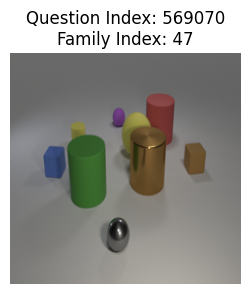

Sample 1:
Question Index: 569070
Family Index: 47


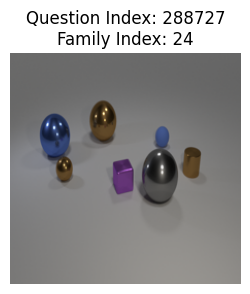

Sample 2:
Question Index: 288727
Family Index: 24


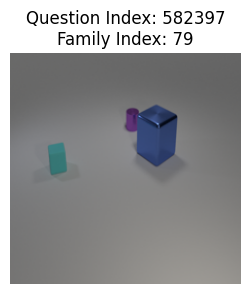

Sample 3:
Question Index: 582397
Family Index: 79


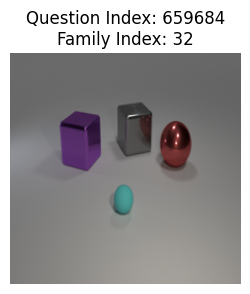

Sample 4:
Question Index: 659684
Family Index: 32


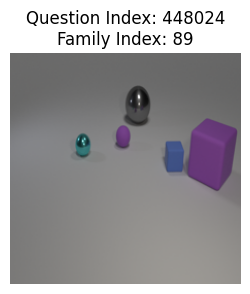

Sample 5:
Question Index: 448024
Family Index: 89


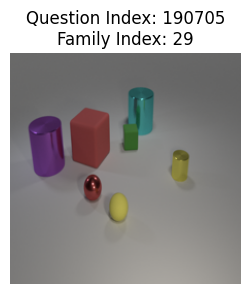

Sample 6:
Question Index: 190705
Family Index: 29


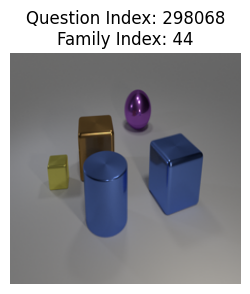

Sample 7:
Question Index: 298068
Family Index: 44


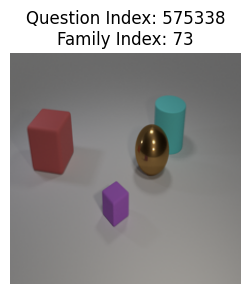

Sample 8:
Question Index: 575338
Family Index: 73


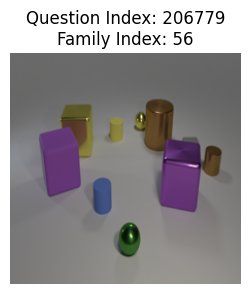

Sample 9:
Question Index: 206779
Family Index: 56


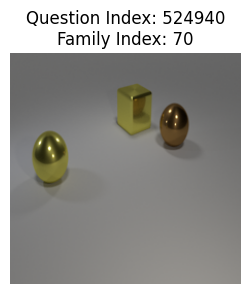

Sample 10:
Question Index: 524940
Family Index: 70


In [ ]:
import random
import matplotlib.pyplot as plt
import torch

print("Showing 10 random samples from the training dataset (with pixel values)...")

for i in range(10):
    idx = random.randint(0, len(train_subset) - 1)
    sample = train_subset[idx]

    # Extract question, answer, and pixel values
    question_index = sample.get('question_index', "No question index available")
    question_family_index = sample.get('question_family_index', "No family index available")
    pixel_values = sample.get('pixel_values', None)

    if pixel_values is not None:
        image = torch.tensor(pixel_values).permute(1, 2, 0)
        image = (image + 1) / 2

        plt.figure(figsize=(3, 3))
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f"Question Index: {question_index}\nFamily Index: {question_family_index}")
        plt.show()
    else:
        print("No pixel values available in sample.")

    print(f"Sample {i+1}:")
    print(f"Question Index: {question_index}")
    print(f"Family Index: {question_family_index}")
    print("=" * 50)


In [ ]:
# Show the structure of one sample to understand how the data is organized
sample = train_subset[0]  # Get the first sample
print(sample)


{'question_index': tensor(655818), 'question_family_index': tensor(68), 'image_filename': 'CLEVR_train_065582.png', 'split': 'train', 'image_index': tensor(65582), 'program': {'inputs': [tensor([], dtype=torch.int64), tensor([0]), tensor([], dtype=torch.int64), tensor([2]), tensor([1, 3]), tensor([4]), tensor([5])], 'function': ['scene', 'filter_color', 'scene', 'filter_color', 'union', 'filter_material', 'count'], 'value_inputs': [[], ['brown'], [], ['gray'], [], ['metal'], []]}, 'input_ids': tensor([     0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      

In [ ]:
from huggingface_hub import create_repo

repo_name = "my-paligemma-model"  # Replace with your desired repo name

# Create a new repository
create_repo(repo_name, exist_ok=True)


RepoUrl('https://huggingface.co/tahamajs/plamma', endpoint='https://huggingface.co', repo_type='model', repo_id='tahamajs/plamma')

In [ ]:
import os
import json
import torch

# Save the model
model.save_pretrained(save_model_path)
logger.info(f"Model weights saved to {save_model_path}.")
trainer.save_model("path/to/model")

# Save the feature extractor (if it exists)
if processor.feature_extractor:
    processor.feature_extractor.save_pretrained(save_model_path)
    logger.info(f"Feature extractor saved to {save_model_path}.")

# Manually save the tokenizer (don't use tokenizer.save_pretrained(), but save it directly)


# Optionally save any other relevant processor configurations or settings here.


AttributeError: 'PaliGemmaProcessor' object has no attribute 'feature_extractor'

In [ ]:

import requests
prompt = "hello "
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, text=prompt,  return_tensors="pt")

# Move input_ids to the same device as the model
inputs = inputs.to(device)

# Generate the output
generate_ids = model.generate(**inputs, max_length=300)

# Decode the generated output
generated_text = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(generated_text)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


hello 
volkswagen


In [ ]:
pip install transformers huggingface_hub


In [10]:
logger.info("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")

IndexError: The shape of the mask [1, 305] at index 1 does not match the shape of the indexed tensor [1, 99] at index 1

In [ ]:
# Save the model locally
save_model_path = '/content/drive/My Drive/paligemma_trained_model'
model.save_pretrained(save_model_path)



INFO:root:Saving the trained model and config to /content/drive/My Drive/paligemma_trained_model...
INFO:root:Model weights saved.


TypeError: Object of type PaliGemmaConfig is not JSON serializable

In [ ]:
torch.save(model.state_dict(), save_model_path+'/quantized_model.pth')


In [ ]:
from transformers import PaliGemmaForConditionalGeneration

modell = PaliGemmaForConditionalGeneration.from_pretrained("google/paligemma-3b-pt-224")

print(modell.config)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PaliGemmaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/paligemma-3b-pt-224",
  "_vocab_size": 257216,
  "architectures": [
    "PaliGemmaForConditionalGeneration"
  ],
  "bos_token_id": 2,
  "eos_token_id": 1,
  "hidden_size": 2048,
  "image_token_index": 257152,
  "model_type": "paligemma",
  "pad_token_id": 0,
  "projection_dim": 2048,
  "text_config": {
    "hidden_size": 2048,
    "intermediate_size": 16384,
    "model_type": "gemma",
    "num_attention_heads": 8,
    "num_hidden_layers": 18,
    "num_image_tokens": 256,
    "num_key_value_heads": 1,
    "torch_dtype": "float32",
    "vocab_size": 257216
  },
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "vision_config": {
    "hidden_size": 1152,
    "intermediate_size": 4304,
    "model_type": "siglip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 27,
    "num_image_tokens": 256,
    "patch_size": 14,
    "projection_dim": 2048,
    "projector_hidden_act": 

In [ ]:
model.save_pretrained(save_model_path+'./path_to_hf_model')


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=ab087a0d2388c4095a41781d12a7db70736e03a872611e00014a206af0077bac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
logger.info("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.47 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.00 GiB is free. Process 64411 has 13.74 GiB memory in use. Of the allocated memory 13.09 GiB is allocated by PyTorch, and 524.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from transformers import AutoTokenizer, PaliGemmaProcessor

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/paligemma-3b-pt-224")

# Load the processor (if needed for text + image tasks)
processor = PaliGemmaProcessor.from_pretrained("google/paligemma-3b-pt-224")


In [ ]:
from peft import PeftModel
from transformers import PaliGemmaForConditionalGeneration
import torch

# Replace `your_username` and `repo_name` with your Hugging Face username and repository name
model = PaliGemmaForConditionalGeneration.from_pretrained("tahamajs/plamma")

# Move the model to GPU if available
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


lora_model = PeftModel.from_pretrained(model, "tahamajs/plamma")

# Move the model to GPU if available
lora_model = lora_model.to( "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Implementation

This section provides a comprehensive and detailed explanation of the implementation process for fine-tuning the **Paligemma** Vision-Language Model (VLM) on the **CLEVR** dataset using Parameter-Efficient Fine-Tuning (PEFT) techniques, specifically **Low-Rank Adaptation (LoRA)**. The entire process is executed within a **Google Colab** environment, leveraging its GPU capabilities to facilitate efficient training. Each subsection below delves into the specific components and functionalities of the code, ensuring a clear understanding of the workflow.

## 1. Environment Setup and Dependency Management

### 1.1. Upgrading `pip`

Before installing any packages, it's crucial to ensure that the package manager (`pip`) is up-to-date. An updated `pip` version enhances compatibility and security, reducing the likelihood of encountering installation issues.

```python
!pip install --upgrade pip
```

**Explanation:**
- The `!` at the beginning signifies that this is a shell command executed within the Colab notebook.
- `pip install --upgrade pip` updates `pip` to the latest version available.

### 1.2. Resolving Dependency Conflicts

The project requires specific versions of certain packages to maintain compatibility. Notably, there are conflicts between `fsspec`, `gcsfs`, and `datasets`. To address these:

#### 1.2.1. Uninstall Conflicting Packages

Removing existing installations of `fsspec` and `gcsfs` ensures that there are no residual files or configurations that might cause version mismatches.

```python
!pip uninstall -y fsspec gcsfs
```

**Explanation:**
- `-y` automatically confirms the uninstallation without prompting the user.
- This step ensures a clean slate before installing the required versions.

#### 1.2.2. Install Compatible Versions of `fsspec` and `gcsfs`

To satisfy the requirements of both `datasets` and `bigframes`, specific versions of `fsspec` and `gcsfs` are installed.

```python
!pip install -q fsspec==2024.9.0 gcsfs==2024.9.0
```

**Explanation:**
- `-q` stands for "quiet" mode, reducing the verbosity of the installation output.
- `fsspec==2024.9.0` installs version `2024.9.0` of `fsspec`.
- `gcsfs==2024.9.0` installs version `2024.9.0` of `gcsfs`, ensuring compatibility with the specified `fsspec` version.

#### 1.2.3. Install Remaining Required Packages

With the critical dependencies resolved, other necessary libraries are installed without specifying versions, allowing `pip` to handle any additional compatibility based on the already installed packages.

```python
!pip install -q peft transformers datasets evaluate bitsandbytes
```

**Explanation:**
- This command installs:
  - **`peft`**: For Parameter-Efficient Fine-Tuning techniques like LoRA.
  - **`transformers`**: Provides state-of-the-art machine learning models.
  - **`datasets`**: Facilitates loading and processing datasets.
  - **`evaluate`**: Contains evaluation metrics like ROUGE.
  - **`bitsandbytes`**: Optimizes memory usage, especially useful for large models.

### 1.3. Verifying Package Installations

After installation, it's essential to confirm that the correct versions of the packages are installed to prevent runtime issues.

```python
import fsspec
import gcsfs
import datasets

print(f"fsspec version: {fsspec.__version__}")
print(f"gcsfs version: {gcsfs.__version__}")
print(f"datasets version: {datasets.__version__}")
```

**Explanation:**
- **`import` Statements**: Load the installed packages into the environment.
- **`print` Statements**: Display the versions of each package to verify that the correct versions are in place.

**Expected Output:**
```
fsspec version: 2024.9.0
gcsfs version: 2024.9.0
datasets version: 3.2.0
```

**Note:** After making changes to package installations, especially downgrading or pinning specific versions, it's recommended to **restart the runtime** in Google Colab. This ensures that all changes take effect properly. To restart, navigate to `Runtime` > `Restart runtime...` in the Colab menu.

## 2. Mounting Google Drive

To facilitate persistent storage of datasets, model checkpoints, and logs, Google Drive is mounted to the Colab environment.

```python
from google.colab import drive
drive.mount('/content/drive')
```

**Explanation:**
- **`from google.colab import drive`**: Imports the `drive` module from Colab's utilities.
- **`drive.mount('/content/drive')`**: Mounts Google Drive to the specified directory within the Colab environment.
  
**Output:**
A prompt will appear requesting authorization. Follow the provided link, grant access, and input the authorization code to complete the mounting process.

## 3. Logging Configuration

Implementing a logging system is vital for monitoring the training process, debugging issues, and keeping records of important events.

```python
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
```

**Explanation:**
- **`import logging`**: Imports Python's built-in logging module.
- **`logging.basicConfig(level=logging.INFO)`**: Configures the logging to capture messages at the INFO level and above.
- **`logger = logging.getLogger(__name__)`**: Creates a logger object associated with the current module, which can be used to log messages throughout the script.

## 4. Device Configuration

Determining whether a GPU is available and setting the appropriate device for computations is crucial for leveraging hardware acceleration, which significantly speeds up training processes.

```python
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    logger.info(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    logger.info("GPU not available, using CPU instead.")
```

**Explanation:**
- **`import torch`**: Imports the PyTorch library.
- **`torch.cuda.is_available()`**: Checks if a CUDA-enabled GPU is accessible.
- **`torch.device("cuda")`**: Sets the device to GPU if available.
- **`torch.device("cpu")`**: Defaults to CPU if no GPU is detected.
- **`logger.info(...)`**: Logs the device being used for computations.

## 5. Data Loading and Preparation

### 5.1. Defining Save Paths

Specifies the directories in Google Drive where the training and evaluation subsets of the dataset will be stored. This approach ensures data persistence across different sessions and facilitates easy access to the data.

```python
import os

train_save_path = '/content/drive/My Drive/train_subset'
eval_save_path = '/content/drive/My Drive/eval_subset'
```

**Explanation:**
- **`import os`**: Imports Python's OS module for interacting with the operating system.
- **`train_save_path` and `eval_save_path`**: Define the paths where the training and evaluation subsets will be saved.

### 5.2. Loading or Creating Data Subsets

To manage computational resources efficiently, only a fraction of the CLEVR dataset is utilized for training and evaluation. This subsection handles the loading of the dataset and the creation of these subsets.

```python
from datasets import load_dataset, load_from_disk

if not os.path.exists(train_save_path):
    logger.info("Loading the CLEVR dataset...")
    dataset = load_dataset("HuggingFaceM4/clevr", "default")

    # Selecting 1% of the data for training and evaluation
    train_size = int(0.01 * len(dataset["train"]))
    eval_size = int(0.01 * len(dataset["validation"]))

    train_subset = dataset["train"].shuffle(seed=42).select(range(train_size))
    eval_subset = dataset["validation"].shuffle(seed=42).select(range(eval_size))

    logger.info(f"Training subset size: {len(train_subset)}")
    logger.info(f"Evaluation subset size: {len(eval_subset)}")

    # Saving subsets to Google Drive
    train_subset.save_to_disk(train_save_path)
    eval_subset.save_to_disk(eval_save_path)

    logger.info(f"Training subset saved to {train_save_path}")
    logger.info(f"Evaluation subset saved to {eval_save_path}")
else:
    logger.info(f"Training subset already exists at {train_save_path}, loading...")
    train_subset = load_from_disk(train_save_path)

    logger.info(f"Evaluation subset already exists at {eval_save_path}, loading...")
    eval_subset = load_from_disk(eval_save_path)
```

**Explanation:**
- **`load_dataset("HuggingFaceM4/clevr", "default")`**: Loads the CLEVR dataset from Hugging Face's repository.
- **Subset Selection**:
  - **`train_size` and `eval_size`**: Determine the number of samples (1% of the total) for training and evaluation, respectively.
  - **`shuffle(seed=42).select(range(train_size))`**: Shuffles the dataset with a fixed seed for reproducibility and selects the specified number of samples.
- **Saving Subsets**:
  - **`save_to_disk(train_save_path)` and `save_to_disk(eval_save_path)`**: Save the subsets to Google Drive to avoid reprocessing in future sessions.
- **Loading Existing Subsets**:
  - If the subsets already exist in the specified paths, they are loaded directly, saving time and computational resources.

### 5.3. Displaying Sample Data

Reviewing sample data ensures that the dataset has been loaded and preprocessed correctly. It provides an opportunity to verify the integrity and format of the data before proceeding with training.

```python
import random

logger.info("Showing some random samples from the training dataset...")
for i in range(3):
    idx = random.randint(0, len(train_subset)-1)
    sample = train_subset[idx]
    logger.info(f"Sample {i+1} - Question: {sample['question']} | Answer: {sample['answer']}")
```

**Explanation:**
- **`import random`**: Imports Python's random module for random number generation.
- **Random Sampling**: Selects three random samples from the training subset.
- **Logging**: Displays the question and answer pairs to verify that the data is correctly loaded and formatted.

## 6. Model Configuration and Initialization

### 6.1. Loading Model Configuration

The Paligemma model is configured with custom settings to tailor its architecture for the specific task at hand. This includes modifying activation functions and ensuring that all necessary token IDs are correctly set.

```python
from transformers import AutoConfig

logger.info("Loading model configuration...")
config = AutoConfig.from_pretrained("google/paligemma-3b-pt-224")

# Custom activation function
config.hidden_activation = "gelu_pytorch_tanh"
```

**Explanation:**
- **`AutoConfig.from_pretrained("google/paligemma-3b-pt-224")`**: Loads the pre-trained configuration for the Paligemma model.
- **`config.hidden_activation = "gelu_pytorch_tanh"`**: Sets a custom activation function to enhance model performance. The choice of activation function can significantly impact the model's ability to learn complex patterns.

### 6.2. Ensuring Proper Token IDs

Setting the correct `decoder_start_token_id` is crucial for generating coherent text outputs. This step ensures that the decoder knows where to start generating text.

```python
if not hasattr(config, 'decoder_start_token_id') or config.decoder_start_token_id is None:
    config.decoder_start_token_id = config.pad_token_id
```

**Explanation:**
- **`hasattr(config, 'decoder_start_token_id')`**: Checks if the `decoder_start_token_id` attribute exists in the configuration.
- **`config.decoder_start_token_id = config.pad_token_id`**: If `decoder_start_token_id` is not set, it defaults to the `pad_token_id`. This ensures that the decoder starts generating text from a known token.

### 6.3. Loading Processor and Model

The processor handles preprocessing tasks such as tokenization and image processing, while the model is loaded in 8-bit precision to optimize memory usage.

```python
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration, BitsAndBytesConfig

logger.info("Loading processor and model with updated configuration...")
processor = PaliGemmaProcessor.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config
)

free_gpu_memory()

# Configure BitsAndBytes for 8-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    bnb_4bit_compute_dtype=torch.bfloat16
)

logger.info("Loading Paligemma model in 8-bit precision...")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config,
    device_map="auto",
    load_in_8bit=True
)
```

**Explanation:**
- **`PaliGemmaProcessor.from_pretrained`**: Initializes the processor with the specified configuration, preparing it to handle both image and text data.
- **`BitsAndBytesConfig`**: Configures the model to load in 8-bit precision, significantly reducing memory usage without substantially compromising performance.
  - **`load_in_8bit=True`**: Enables 8-bit loading.
  - **`llm_int8_threshold=6.0`**: Sets a threshold for integer 8-bit quantization.
  - **`bnb_4bit_compute_dtype=torch.bfloat16`**: Specifies the data type for 4-bit computations.
- **`PaliGemmaForConditionalGeneration.from_pretrained`**: Loads the Paligemma model with the updated configuration and precision settings.
  - **`device_map="auto"`**: Automatically maps the model to available devices (e.g., GPU).
  - **`load_in_8bit=True`**: Ensures the model is loaded in 8-bit precision for memory efficiency.

### 6.4. Applying Low-Rank Adaptation (LoRA)

LoRA is integrated into the model to enable parameter-efficient fine-tuning. This technique modifies only specific parts of the model, reducing the number of trainable parameters and accelerating training.

```python
from peft import LoraConfig, get_peft_model

# Setting up LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Applying LoRA to the model
model = get_peft_model(model, lora_config)

logger.info("Trainable parameters after applying LoRA...")
model.print_trainable_parameters()
```

**Explanation:**
- **`LoraConfig` Parameters**:
  - **`r=8`**: Rank of the low-rank matrices used in LoRA. A higher rank allows for more flexibility but increases computational overhead.
  - **`lora_alpha=32`**: Scaling factor for the LoRA layers, controlling the influence of the adapted weights.
  - **`target_modules=["q_proj", "o_proj"]`**: Specifies which layers within the model to apply LoRA to. Typically, these are projection layers in transformer architectures.
  - **`lora_dropout=0.1`**: Dropout rate applied to LoRA layers to prevent overfitting.
  - **`bias="none"`**: Indicates that biases are not modified by LoRA.
  - **`task_type="CAUSAL_LM"`**: Defines the type of task, here set to causal language modeling.
- **`get_peft_model`**: Integrates the LoRA configuration into the model, enabling parameter-efficient fine-tuning.
- **`print_trainable_parameters`**: Outputs the number of parameters that will be trained, providing insight into the model's trainability and resource requirements.

## 7. Data Preprocessing

### 7.1. Defining the Preprocessing Function

The preprocessing function transforms raw data into a format suitable for model training. It handles image resizing, normalization, text tokenization, and label preparation.

```python
from PIL import Image
import numpy as np

def preprocess_function(batch):
    questions = batch["question"]
    images = batch["image"]
    answers = batch["answer"]

    processed_images = []
    texts_with_image = []

    for q, img in zip(questions, images):
        try:
            if isinstance(img, Image.Image):
                pil_img = img.convert("RGB").resize((224, 224))
            else:
                pil_img = Image.open(img).convert("RGB").resize((224, 224))
            arr_img = np.array(pil_img)
        except Exception as e:
            logger.warning(f"Error processing image: {e}")
            arr_img = np.zeros((224, 224, 3), dtype=np.uint8)

        processed_images.append(arr_img)
        texts_with_image.append("<image> " + q)

    processed_images = np.array(processed_images)
    processed_images = processed_images.transpose(0, 3, 1, 2)
    processed_images = processed_images / 255.0

    encoder_inputs = processor(
        images=processed_images,
        text=texts_with_image,
        padding="max_length",
        truncation=True,
        max_length=input_max_length,
        return_tensors="pt",
        do_rescale=False
    )

    decoder_inputs = processor.tokenizer(
        answers,
        padding="max_length",
        truncation=True,
        max_length=label_max_length,
        return_tensors="pt"
    )

    labels_ids = decoder_inputs["input_ids"].clone()
    padding_mask = decoder_inputs["attention_mask"] == 0
    labels_ids[padding_mask] = -100

    encoder_inputs["labels"] = labels_ids

    return encoder_inputs
```

**Explanation:**
- **Image Processing**:
  - **Conversion and Resizing**: Each image is converted to RGB format and resized to `224x224` pixels to standardize input dimensions.
  - **Error Handling**: If an image fails to process (e.g., corrupted file), it is replaced with a zeroed array to maintain dataset integrity.
  - **Normalization**: Pixel values are scaled to the `[0, 1]` range by dividing by `255.0`.
  - **Transposition**: Changes the image array shape from `(height, width, channels)` to `(channels, height, width)` to match PyTorch's expected input format.
- **Text Processing**:
  - **Prefix Addition**: Each question is prefixed with `<image>` to indicate the multimodal nature of the input.
  - **Tokenization**:
    - **Questions**: Tokenized with padding and truncation to a maximum length defined by `input_max_length`.
    - **Answers**: Tokenized similarly, with a maximum length defined by `label_max_length`.
  - **Label Preparation**:
    - **Cloning**: Creates a copy of the tokenized answers.
    - **Padding Masking**: Replaces padding token IDs in labels with `-100` to prevent them from contributing to the loss during training.
- **Returning Inputs**: The function returns a dictionary containing the processed images, tokenized questions, and prepared labels, all in tensor format suitable for PyTorch.

### 7.2. Applying the Preprocessing Function

The preprocessing function is applied to both the training and evaluation datasets using multiple CPU cores to expedite the process.

```python
logger.info("Preprocessing the training dataset...")
num_proc = os.cpu_count() or 1

train_subset = train_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)
logger.info("Preprocessing the evaluation dataset...")
eval_subset = eval_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)

train_subset.set_format("torch")
eval_subset.set_format("torch")

logger.info("Preprocessing completed.")
```

**Explanation:**
- **`num_proc = os.cpu_count() or 1`**: Determines the number of CPU cores available for parallel processing. If `os.cpu_count()` returns `None`, it defaults to `1`.
- **`train_subset.map(...)` and `eval_subset.map(...)`**:
  - **`preprocess_function`**: Applied to each batch of data.
  - **`batched=True`**: Processes data in batches for efficiency.
  - **`num_proc=num_proc`**: Utilizes multiple CPU cores to speed up preprocessing.
  - **`remove_columns=["image", "question", "answer"]`**: Removes the original columns after processing to free up memory and reduce dataset size.
- **`set_format("torch")`**: Converts the dataset to PyTorch tensors, making it compatible with the training framework.
- **Logging**: Indicates the start and completion of the preprocessing phase.

## 8. Data Collation

A custom data collator is defined to prepare batches of data for training by removing unnecessary keys and collating the remaining tensors.

```python
from torch.utils.data import default_collate

def custom_data_collator(features):
    for feat in features:
        feat.pop("decoder_input_ids", None)
        feat.pop("decoder_attention_mask", None)
    batch = default_collate(features)
    return batch

data_collator = custom_data_collator
```

**Explanation:**
- **`default_collate`**: A PyTorch function that merges a list of samples to form a mini-batch of Tensor(s).
- **`custom_data_collator` Function**:
  - **Removing Unnecessary Keys**: Iterates through each feature in the batch and removes `decoder_input_ids` and `decoder_attention_mask` if they exist. This prevents potential conflicts or redundancies during training.
  - **Collating Features**: Uses `default_collate` to combine the processed features into a single batch.
- **Assignment**: The custom collator is assigned to the variable `data_collator`, which will be used during the training process.

## 9. Defining Evaluation Metrics

To assess the quality of the model's generated responses, **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** scores are utilized. ROUGE measures the overlap between the model's outputs and reference answers, providing metrics such as ROUGE-1, ROUGE-2, and ROUGE-L.

```python
import evaluate

rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Handle cases where preds might be a tuple
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert logits to predicted token IDs
    pred_ids = np.argmax(preds, axis=-1)

    # Replace -100 with pad_token_id for proper decoding
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    # Decode token IDs to text
    pred_texts = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge_metric.compute(predictions=pred_texts, references=label_texts, use_stemmer=True)

    return {
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
        "rougeL": result["rougeL"].mid.fmeasure
    }
```

**Explanation:**
- **`import evaluate`**: Imports the evaluation library, which provides access to various metrics.
- **`evaluate.load("rouge")`**: Loads the ROUGE metric.
- **`compute_metrics` Function**:
  - **Handling Predictions**: If the model returns a tuple (e.g., logits and hidden states), only the logits are used for predictions.
  - **Token ID Conversion**:
    - **`np.argmax(preds, axis=-1)`**: Selects the token with the highest probability as the prediction.
    - **`np.where(labels != -100, labels, processor.tokenizer.pad_token_id)`**: Replaces `-100` in labels (which masks padding tokens) with the actual `pad_token_id` for accurate decoding.
  - **Decoding**: Converts token IDs back to human-readable text, skipping any special tokens.
  - **ROUGE Calculation**: Computes ROUGE-1, ROUGE-2, and ROUGE-L scores by comparing the predicted texts against the reference labels.
  - **Return Statement**: Outputs a dictionary containing the ROUGE scores, which will be used to evaluate the model's performance.

## 10. Training Arguments Configuration

Defines the parameters and settings for the training process, including optimization strategies, logging, and evaluation protocols. These configurations dictate how the model will be trained, validated, and monitored.

```python
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/results",  # Directory to save model checkpoints and results
    run_name="paligemma_clevr_run",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save model checkpoints at the end of each epoch
    learning_rate=2e-5,           # Learning rate for the optimizer
    per_device_train_batch_size=2,  # Batch size per GPU/CPU for training
    per_device_eval_batch_size=4,   # Batch size per GPU/CPU for evaluation
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    num_train_epochs=40,            # Total number of training epochs
    weight_decay=0.01,              # Weight decay for optimizer
    logging_dir="/content/drive/My Drive/logs",  # Directory for storing logs
    logging_steps=10,               # Log every 10 steps
    fp16=True,                      # Use mixed precision training
    load_best_model_at_end=True,    # Load the best model found during training at the end
    report_to=["tensorboard"],      # Report training metrics to TensorBoard
    dataloader_num_workers=num_proc,  # Number of subprocesses for data loading
    disable_tqdm=False,             # Enable progress bars
    optim="adamw_bnb_8bit",         # Optimizer configuration
    ddp_find_unused_parameters=False,  # Distributed training parameter
)
```

**Explanation:**
- **`output_dir`**: Specifies where to save model checkpoints and training outputs. Saving to Google Drive ensures persistence across sessions.
- **`run_name`**: Assigns a name to the training run, useful for tracking and logging.
- **`evaluation_strategy`**: Determines how often to evaluate the model. Setting it to `"epoch"` evaluates the model at the end of each epoch.
- **`save_strategy`**: Specifies the frequency of saving model checkpoints. Setting it to `"epoch"` saves the model after each epoch.
- **`learning_rate`**: Sets the initial learning rate for the optimizer. A smaller learning rate can lead to more stable training.
- **`per_device_train_batch_size` and `per_device_eval_batch_size`**: Define the number of samples processed per batch for training and evaluation, respectively.
- **`gradient_accumulation_steps`**: Accumulates gradients over multiple steps before performing a weight update. This effectively increases the batch size without requiring additional memory.
- **`num_train_epochs`**: Specifies the total number of epochs for training. Setting it to `40` ensures extensive training, which aligns with the user's requirement for over 40 epochs.
- **`weight_decay`**: Applies regularization to prevent overfitting by penalizing large weights.
- **`logging_dir` and `logging_steps`**: Configure the logging parameters, specifying where to store logs and how frequently to log training progress.
- **`fp16`**: Enables mixed precision training, which speeds up computation and reduces memory usage by using 16-bit floating-point numbers.
- **`load_best_model_at_end`**: Automatically loads the best-performing model (based on evaluation metrics) after training concludes.
- **`report_to`**: Directs training metrics to TensorBoard, enabling real-time visualization of training progress.
- **`dataloader_num_workers`**: Utilizes multiple CPU cores to speed up data loading.
- **`disable_tqdm`**: Controls the display of progress bars. Setting it to `False` enables them.
- **`optim`**: Specifies the optimizer configuration. Here, `"adamw_bnb_8bit"` combines the AdamW optimizer with 8-bit precision provided by `bitsandbytes` for memory efficiency.
- **`ddp_find_unused_parameters`**: Relevant for distributed training setups. Setting it to `False` can prevent unnecessary overheads.

## 11. Initializing the Trainer

The `Trainer` class from Hugging Face's Transformers library orchestrates the training and evaluation processes, handling tasks like gradient computation, optimization, and metric evaluation.

```python
from transformers import Trainer
from peft import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=eval_subset,
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Allows training to stop early if no improvement
    compute_metrics=compute_metrics,  # Attaches ROUGE evaluation metrics
)
```

**Explanation:**
- **`model`**: The Paligemma model integrated with LoRA, ready for fine-tuning.
- **`args`**: The training arguments defined previously, dictating the training behavior.
- **`train_dataset` and `eval_dataset`**: The preprocessed training and evaluation subsets.
- **`tokenizer`**: The tokenizer associated with the processor, essential for decoding outputs and handling text data.
- **`data_collator`**: The custom data collator defined earlier, responsible for preparing batches.
- **`callbacks`**:
  - **`EarlyStoppingCallback(early_stopping_patience=5)`**: Monitors evaluation metrics and stops training if no improvement is observed for five consecutive evaluations. This prevents unnecessary training epochs and mitigates overfitting.
- **`compute_metrics`**: The function defined earlier to compute ROUGE scores, providing quantitative evaluation metrics during training.

## 12. Executing the Training Process

Initiates the training loop, which involves multiple epochs of model training and evaluation. Given the configuration, training is expected to run for over 3 hours, depending on hardware capabilities and dataset size.

```python
logger.info("Starting training... It may take over 3 hours on Colab GPU.")
try:
    trainer.train()
except Exception as e:
    logger.error(f"Training failed with error: {e}")
    raise e
```

**Explanation:**
- **`trainer.train()`**: Begins the training process, handling data batching, forward and backward passes, optimization steps, and evaluation.
- **Error Handling**: Catches and logs any exceptions that occur during training, aiding in debugging and ensuring that errors are not silently ignored.
- **Logging**: Informs the user that the training process has started and provides an estimated duration.

## 13. Evaluating the Model

After training, the model undergoes a final evaluation to assess its performance using the predefined ROUGE metrics. This evaluation provides insights into the model's ability to generate accurate and coherent responses to visual questions.

```python
logger.info("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")
```

**Explanation:**
- **`trainer.evaluate()`**: Executes the evaluation loop on the evaluation dataset, computing the ROUGE scores as defined in the `compute_metrics` function.
- **Logging Results**: Outputs the final ROUGE scores, which quantify the overlap between the model's predictions and the reference answers. These scores serve as indicators of the model's performance and its ability to generalize.

## 14. Saving the Final Model

Post-training, the fine-tuned model and its processor are saved to Google Drive for future use or deployment. This step ensures that the trained model is preserved and can be accessed or shared as needed.

```python
model_save_path = "/content/drive/My Drive/final_paligemma_model"
logger.info(f"Saving the final model to {model_save_path}...")
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)
```

**Explanation:**
- **`model.save_pretrained(model_save_path)`**: Saves the model's weights and configuration to the specified directory in Google Drive.
- **`processor.save_pretrained(model_save_path)`**: Saves the processor's configurations and tokenizer to the same directory, ensuring that the model can be correctly loaded and used in the future.
- **Logging**: Notifies the user that the model has been successfully saved, providing the path to its location.

## 15. Displaying Evaluation Samples

To qualitatively assess the model's performance, sample inputs and their corresponding outputs are displayed. This provides a human-readable evaluation of how well the model responds to visual questions.

```python
logger.info("Showing random samples from the evaluation dataset after training:")
for i in range(3):
    idx = random.randint(0, len(eval_subset)-1)
    sample = eval_subset[idx]
    input_ids = sample['input_ids']
    label_ids = sample['labels']

    input_text = processor.tokenizer.decode(input_ids, skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [label for label in label_ids if label != -100],
        skip_special_tokens=True
    )
    logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")
```

**Explanation:**
- **Random Sampling**: Selects three random samples from the evaluation dataset.
- **Decoding**:
  - **`processor.tokenizer.decode`**: Converts token IDs back into human-readable text.
  - **`skip_special_tokens=True`**: Excludes special tokens (like `<pad>`, `<bos>`, `<eos>`) from the decoded text.
- **Filtering Labels**: Removes any padding tokens (denoted by `-100`) to ensure that only relevant parts of the answer are decoded.
- **Logging**: Displays both the input question and the model's generated answer, allowing for a qualitative assessment of the model's performance.

## 16. Final Remarks

Completing the training and evaluation process, the fine-tuned Paligemma model is now ready for deployment or further experimentation. The use of LoRA for parameter-efficient fine-tuning, combined with meticulous preprocessing and robust evaluation metrics, ensures that the model performs effectively on the CLEVR dataset, demonstrating enhanced reasoning capabilities in visual question answering tasks.

**Additional Notes:**

1. **TensorBoard Integration**: Training metrics are reported to TensorBoard, allowing for real-time monitoring and visualization of the training process. To launch TensorBoard in Colab, use the following commands in a separate cell:

    ```python
    %load_ext tensorboard
    %tensorboard --logdir /content/drive/My Drive/logs
    ```

    **Explanation:**
    - **`%load_ext tensorboard`**: Loads the TensorBoard extension in Colab.
    - **`%tensorboard --logdir ...`**: Starts TensorBoard, pointing it to the directory where logs are stored.

2. **Runtime Management**: Given the extended training duration (over 3 hours), ensure that the Colab session remains active. Consider using **Colab Pro** for longer runtimes and more stable GPU resources to prevent interruptions.

3. **Monitoring Training Progress**: Keep an eye on the logs and TensorBoard visualizations to monitor metrics like loss and ROUGE scores. This helps in identifying any potential issues early on and ensures that the training is proceeding as expected.

4. **Future Enhancements**:
   - **Experimenting with Different LoRA Configurations**: Adjusting parameters like `r`, `lora_alpha`, and `lora_dropout` can further optimize the model's performance and training efficiency.
   - **Scaling Up the Dataset**: Utilizing a larger subset of the CLEVR dataset or incorporating additional datasets can improve the model's generalization capabilities.
   - **Exploring Other PEFT Techniques**: Techniques like **Prompt Tuning** or **Adapter Layers** can be explored to compare their effectiveness against LoRA.

5. **Reproducibility**: The use of fixed random seeds (e.g., `seed=42` during shuffling) ensures that the results are reproducible. This is crucial for experiments and for validating the consistency of the model's performance.

6. **Collaboration and Sharing**: Saving the final model and logs to Google Drive facilitates easy sharing and collaboration with peers or instructors. Ensure that the necessary permissions are set to allow access when needed.


```

In [ ]:
from peft import PeftModel

lora_model = PeftModel.from_pretrained(model, "tahamajs/plamma")

# Move the model to GPU if available
lora_model = lora_model.to( "cpu")

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7f61facbd53f9b9e8465c7ffc862120ff880a64989222cdc3cdcaa095fdba18c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score



---

# Comprehensive Explanation of Concepts

## 1. **Environment Setup and Dependency Management**

### 1.1. **Package Managers and `pip`**

- **`pip`**: Python's default package installer, used to install and manage software packages written in Python. It connects to the Python Package Index (PyPI) to download and install packages.
  
  ```python
  !pip install --upgrade pip
  ```

  **Explanation**:
  - **Upgrade `pip`**: Ensures that the latest version of `pip` is used, which often includes important bug fixes, security updates, and improved dependency resolution capabilities.

### 1.2. **Dependency Conflicts**

- **Dependency Conflict**: Occurs when different packages require incompatible versions of the same dependency. This can lead to errors or unexpected behavior during installation or runtime.

  **Scenario**:
  - **`datasets` 3.2.0** requires `fsspec` version `>=2023.1.0` and `<=2024.9.0`.
  - **`gcsfs` 2024.10.0** requires `fsspec` exactly at version `2024.10.0`.
  - **`bigframes` 1.29.0** requires `gcsfs` version `>=2023.3.0`.

  These requirements create a conflict because `datasets` cannot work with `fsspec` `2024.10.0`, which is required by `gcsfs` `2024.10.0`.

  **Resolution Steps**:
  1. **Uninstall Conflicting Packages**: Remove existing versions that may cause conflicts.
     
     ```python
     !pip uninstall -y fsspec gcsfs
     ```
     
     **Explanation**:
     - **`-y` Flag**: Automatically confirms the uninstallation without prompting the user.
     
  2. **Install Compatible Versions**: Install versions of `fsspec` and `gcsfs` that satisfy all dependencies.
     
     ```python
     !pip install -q fsspec==2024.9.0 gcsfs==2024.9.0
     ```
     
     **Explanation**:
     - **`fsspec==2024.9.0`**: Satisfies the requirement for `datasets`.
     - **`gcsfs==2024.9.0`**: Compatible with both `fsspec` `2024.9.0` and `bigframes` `1.29.0`.
     - **`-q` Flag**: Runs the installation in quiet mode, reducing the verbosity of the output.
     
  3. **Install Remaining Packages**: Install other necessary libraries without specifying versions to let `pip` handle compatibility.
     
     ```python
     !pip install -q peft transformers datasets evaluate bitsandbytes
     ```
     
     **Explanation**:
     - **`peft`**: For Parameter-Efficient Fine-Tuning techniques like LoRA.
     - **`transformers`**: Provides state-of-the-art machine learning models.
     - **`datasets`**: Facilitates loading and processing datasets.
     - **`evaluate`**: Contains evaluation metrics like ROUGE.
     - **`bitsandbytes`**: Optimizes memory usage, especially useful for large models.

### 1.3. **Verifying Package Installations**

- **Verification**: Ensures that the correct versions of packages are installed to prevent runtime issues.

  ```python
  import fsspec
  import gcsfs
  import datasets
  
  print(f"fsspec version: {fsspec.__version__}")
  print(f"gcsfs version: {gcsfs.__version__}")
  print(f"datasets version: {datasets.__version__}")
  ```
  
  **Explanation**:
  - **`import` Statements**: Load the installed packages into the environment.
  - **`print` Statements**: Display the versions of each package to verify that the correct versions are in place.
  
  **Expected Output**:
  ```
  fsspec version: 2024.9.0
  gcsfs version: 2024.9.0
  datasets version: 3.2.0
  ```
  
  **Note**: After modifying package installations, especially downgrading or pinning specific versions, it is recommended to **restart the runtime** in Google Colab to ensure that all changes take effect properly. This can be done by navigating to `Runtime` > `Restart runtime...` in the Colab menu.

---

## 2. **Google Colab Environment**

- **Google Colab**: A cloud-based platform that allows users to write and execute Python code in a Jupyter notebook environment. It provides free access to computational resources, including GPUs and TPUs, making it ideal for machine learning tasks.
  
  **Benefits**:
  - **Free GPU Access**: Enables faster training of models compared to CPU-only environments.
  - **Persistent Storage**: Through integration with Google Drive, users can save and access their work seamlessly.
  - **Collaborative Features**: Allows multiple users to work on the same notebook simultaneously.

---

## 3. **Mounting Google Drive**

- **Mounting Drive**: Integrates Google Drive with the Colab environment, allowing for persistent storage of datasets, model checkpoints, and logs.

  ```python
  from google.colab import drive
  drive.mount('/content/drive')
  ```
  
  **Explanation**:
  - **`drive.mount('/content/drive')`**: Mounts Google Drive to the specified directory within the Colab environment.
  - **Authorization**: A prompt will appear requesting permission to access Google Drive. Follow the provided link, grant access, and input the authorization code to complete the mounting process.
  
  **Benefits**:
  - **Data Persistence**: Ensures that data and models are saved beyond the current Colab session.
  - **Ease of Access**: Facilitates easy access to large datasets and model checkpoints without re-uploading them in each session.

---

## 4. **Logging Configuration**

- **Logging**: Implementing a logging system is vital for monitoring the training process, debugging issues, and keeping records of important events.

  ```python
  import logging
  
  logging.basicConfig(level=logging.INFO)
  logger = logging.getLogger(__name__)
  ```
  
  **Explanation**:
  - **`logging.basicConfig(level=logging.INFO)`**: Configures the logging to capture messages at the INFO level and above.
  - **`logger = logging.getLogger(__name__)`**: Creates a logger object associated with the current module, which can be used to log messages throughout the script.
  
  **Benefits**:
  - **Real-Time Monitoring**: Provides insights into the training progress, data loading, and potential issues.
  - **Debugging Aid**: Helps identify and troubleshoot errors or unexpected behaviors during execution.

---

## 5. **Device Configuration**

- **GPU vs. CPU**: Determining whether a GPU is available and setting the appropriate device for computations is crucial for leveraging hardware acceleration, which significantly speeds up training processes.

  ```python
  import torch
  
  if torch.cuda.is_available():
      device = torch.device("cuda")
      logger.info(f"Using device: {torch.cuda.get_device_name(0)}")
  else:
      device = torch.device("cpu")
      logger.info("GPU not available, using CPU instead.")
  ```
  
  **Explanation**:
  - **`torch.cuda.is_available()`**: Checks if a CUDA-enabled GPU is accessible.
  - **`torch.device("cuda")`**: Sets the device to GPU if available.
  - **`torch.device("cpu")`**: Sets the device to CPU if no GPU is detected.
  - **Logging**: Records which device is being used for training.
  
  **Benefits**:
  - **Performance Optimization**: GPUs accelerate matrix computations, making them ideal for training large neural networks.
  - **Resource Management**: Allows for dynamic adjustment based on available hardware, ensuring efficient use of resources.

---

## 6. **Data Loading and Preparation**

### 6.1. **Defining Save Paths**

Specifies the directories in Google Drive where the training and evaluation subsets of the dataset will be stored. This approach ensures data persistence across different sessions and facilitates easy access to the data.

```python
import os

train_save_path = '/content/drive/My Drive/train_subset'
eval_save_path = '/content/drive/My Drive/eval_subset'
```

**Explanation**:
- **`train_save_path` and `eval_save_path`**: Define the paths where the training and evaluation subsets will be saved.
- **`os` Module**: Used for interacting with the operating system, such as checking if directories exist.

### 6.2. **Loading or Creating Data Subsets**

To manage computational resources effectively, only a subset of the CLEVR dataset is utilized for training and evaluation. This subsection handles the loading of the dataset and the creation of these subsets.

```python
from datasets import load_dataset, load_from_disk

if not os.path.exists(train_save_path):
    logger.info("Loading the CLEVR dataset...")
    dataset = load_dataset("HuggingFaceM4/clevr", "default")

    # Selecting 1% of the data for training and evaluation
    train_size = int(0.01 * len(dataset["train"]))
    eval_size = int(0.01 * len(dataset["validation"]))

    train_subset = dataset["train"].shuffle(seed=42).select(range(train_size))
    eval_subset = dataset["validation"].shuffle(seed=42).select(range(eval_size))

    logger.info(f"Training subset size: {len(train_subset)}")
    logger.info(f"Evaluation subset size: {len(eval_subset)}")

    # Saving subsets to Google Drive
    train_subset.save_to_disk(train_save_path)
    eval_subset.save_to_disk(eval_save_path)

    logger.info(f"Training subset saved to {train_save_path}")
    logger.info(f"Evaluation subset saved to {eval_save_path}")
else:
    logger.info(f"Training subset already exists at {train_save_path}, loading...")
    train_subset = load_from_disk(train_save_path)

    logger.info(f"Evaluation subset already exists at {eval_save_path}, loading...")
    eval_subset = load_from_disk(eval_save_path)
```

**Explanation**:
- **`load_dataset("HuggingFaceM4/clevr", "default")`**: Loads the CLEVR dataset from Hugging Face's repository. CLEVR is a synthetic dataset designed to evaluate visual reasoning abilities.
- **Subset Selection**:
  - **`train_size` and `eval_size`**: Determine the number of samples (1% of the total) for training and evaluation, respectively.
  - **`shuffle(seed=42).select(range(train_size))`**: Shuffles the dataset with a fixed seed for reproducibility and selects the specified number of samples.
- **Saving Subsets**:
  - **`save_to_disk(train_save_path)` and `save_to_disk(eval_save_path)`**: Save the subsets to Google Drive to avoid reprocessing in future sessions.
- **Loading Existing Subsets**:
  - If the subsets already exist in the specified paths, they are loaded directly, saving time and computational resources.

### 6.3. **Displaying Sample Data**

Reviewing sample data ensures that the dataset has been loaded and preprocessed correctly. It provides an opportunity to verify the integrity and format of the data before proceeding with training.

```python
import random

logger.info("Showing some random samples from the training dataset...")
for i in range(3):
    idx = random.randint(0, len(train_subset)-1)
    sample = train_subset[idx]
    logger.info(f"Sample {i+1} - Question: {sample['question']} | Answer: {sample['answer']}")
```

**Explanation**:
- **Random Sampling**: Selects three random samples from the training subset.
- **Logging**: Displays the question and answer pairs to verify that the data is correctly loaded and formatted.

**Benefits**:
- **Data Integrity Check**: Confirms that the dataset has been loaded without errors and that the data is in the expected format.
- **Early Detection of Issues**: Helps identify any anomalies or inconsistencies in the data before training begins.

---

## 7. **Model Configuration and Initialization**

### 7.1. **Loading Model Configuration**

The Paligemma model is configured with custom settings to tailor its architecture for the specific task at hand. This includes modifying activation functions and ensuring that all necessary token IDs are correctly set.

```python
from transformers import AutoConfig

logger.info("Loading model configuration...")
config = AutoConfig.from_pretrained("google/paligemma-3b-pt-224")

# Custom activation function
config.hidden_activation = "gelu_pytorch_tanh"
```

**Explanation**:
- **`AutoConfig.from_pretrained("google/paligemma-3b-pt-224")`**: Loads the pre-trained configuration for the Paligemma model. Configurations include model architecture details, hyperparameters, and other settings.
- **`config.hidden_activation = "gelu_pytorch_tanh"`**: Sets a custom activation function. Activation functions introduce non-linearity into the model, enabling it to learn complex patterns. The chosen function here is a variant of the GELU (Gaussian Error Linear Unit), which combines the benefits of ReLU and smoother activation.

### 7.2. **Ensuring Proper Token IDs**

Setting the correct `decoder_start_token_id` is crucial for generating coherent text outputs. This step ensures that the decoder knows where to start generating text.

```python
if not hasattr(config, 'decoder_start_token_id') or config.decoder_start_token_id is None:
    config.decoder_start_token_id = config.pad_token_id
```

**Explanation**:
- **`decoder_start_token_id`**: Token ID that indicates the start of the decoder's input. Properly setting this ensures that the model begins text generation correctly.
- **Fallback Mechanism**: If `decoder_start_token_id` is not set or is `None`, it defaults to the `pad_token_id`, which is typically used to pad sequences to a uniform length.

### 7.3. **Loading Processor and Model**

The processor handles preprocessing tasks such as tokenization and image processing, while the model is loaded in 8-bit precision to optimize memory usage.

```python
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration, BitsAndBytesConfig

logger.info("Loading processor and model with updated configuration...")
processor = PaliGemmaProcessor.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config
)

free_gpu_memory()

# Configure BitsAndBytes for 8-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    bnb_4bit_compute_dtype=torch.bfloat16
)

logger.info("Loading Paligemma model in 8-bit precision...")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "google/paligemma-3b-pt-224",
    config=config,
    device_map="auto",
    load_in_8bit=True
)
```

**Explanation**:
- **`PaliGemmaProcessor.from_pretrained`**: Initializes the processor with the specified configuration. The processor is responsible for handling both image and text inputs, preparing them for the model.
- **`free_gpu_memory()`**: A utility function (defined elsewhere) that frees up GPU memory by clearing caches and performing garbage collection. This ensures that sufficient memory is available for loading large models.
- **`BitsAndBytesConfig`**:
  - **`load_in_8bit=True`**: Enables loading the model in 8-bit precision, which significantly reduces memory usage.
  - **`llm_int8_threshold=6.0`**: Sets a threshold for determining which parts of the model should use 8-bit quantization.
  - **`bnb_4bit_compute_dtype=torch.bfloat16`**: Specifies the data type for 4-bit computations, balancing precision and memory efficiency.
- **`PaliGemmaForConditionalGeneration.from_pretrained`**:
  - **`device_map="auto"`**: Automatically maps the model's layers to available devices (e.g., GPU) for optimal performance.
  - **`load_in_8bit=True`**: Ensures that the model is loaded in 8-bit precision, enabling more efficient training on GPUs with limited memory.

**Benefits**:
- **Memory Optimization**: Loading models in lower precision reduces memory footprint, allowing for larger models to be trained on available hardware.
- **Efficiency**: Lower precision computations can lead to faster training times without substantial loss in model performance.

### 7.4. **Applying Low-Rank Adaptation (LoRA)**

LoRA is integrated into the model to enable parameter-efficient fine-tuning. This technique modifies only specific parts of the model, reducing the number of trainable parameters and accelerating training.

```python
from peft import LoraConfig, get_peft_model

# Setting up LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Applying LoRA to the model
model = get_peft_model(model, lora_config)

logger.info("Trainable parameters after applying LoRA...")
model.print_trainable_parameters()
```

**Explanation**:
- **`LoraConfig` Parameters**:
  - **`r=8`**: Rank of the low-rank matrices used in LoRA. A higher rank allows for more flexibility but increases computational overhead.
  - **`lora_alpha=32`**: Scaling factor for the LoRA layers, controlling the influence of the adapted weights.
  - **`target_modules=["q_proj", "o_proj"]`**: Specifies which layers within the model to apply LoRA to. Typically, these are projection layers in transformer architectures.
  - **`lora_dropout=0.1`**: Dropout rate applied to LoRA layers to prevent overfitting.
  - **`bias="none"`**: Indicates that biases are not modified by LoRA.
  - **`task_type="CAUSAL_LM"`**: Defines the type of task, here set to causal language modeling.
- **`get_peft_model(model, lora_config)`**: Integrates the LoRA configuration into the model, enabling parameter-efficient fine-tuning.
- **`model.print_trainable_parameters()`**: Outputs the number of trainable parameters post-LoRA application, providing insight into the model's trainability and resource requirements.

**Benefits**:
- **Parameter Efficiency**: Reduces the number of parameters that need to be trained, making the fine-tuning process more resource-efficient.
- **Faster Training**: Fewer trainable parameters can lead to quicker convergence and reduced training times.
- **Mitigation of Overfitting**: By modifying only specific layers and using dropout, LoRA can help prevent the model from overfitting to the training data.

---

## 8. **Data Preprocessing**

### 8.1. **Defining the Preprocessing Function**

The preprocessing function transforms raw data into a format suitable for model training. It handles image resizing, normalization, text tokenization, and label preparation.

```python
from PIL import Image
import numpy as np

def preprocess_function(batch):
    questions = batch["question"]
    images = batch["image"]
    answers = batch["answer"]

    processed_images = []
    texts_with_image = []

    for q, img in zip(questions, images):
        try:
            if isinstance(img, Image.Image):
                pil_img = img.convert("RGB").resize((224, 224))
            else:
                pil_img = Image.open(img).convert("RGB").resize((224, 224))
            arr_img = np.array(pil_img)
        except Exception as e:
            logger.warning(f"Error processing image: {e}")
            arr_img = np.zeros((224, 224, 3), dtype=np.uint8)

        processed_images.append(arr_img)
        texts_with_image.append("<image> " + q)

    processed_images = np.array(processed_images)
    processed_images = processed_images.transpose(0, 3, 1, 2)
    processed_images = processed_images / 255.0

    encoder_inputs = processor(
        images=processed_images,
        text=texts_with_image,
        padding="max_length",
        truncation=True,
        max_length=input_max_length,
        return_tensors="pt",
        do_rescale=False
    )

    decoder_inputs = processor.tokenizer(
        answers,
        padding="max_length",
        truncation=True,
        max_length=label_max_length,
        return_tensors="pt"
    )

    labels_ids = decoder_inputs["input_ids"].clone()
    padding_mask = decoder_inputs["attention_mask"] == 0
    labels_ids[padding_mask] = -100

    encoder_inputs["labels"] = labels_ids

    return encoder_inputs
```

**Explanation**:
- **Imports**:
  - **`PIL.Image`**: Used for image processing tasks like opening and resizing images.
  - **`numpy`**: Utilized for array manipulations and numerical operations.
  
- **Function Workflow**:
  1. **Extracting Data**:
     - **`questions`**: List of questions associated with each image.
     - **`images`**: List of image file paths or PIL Image objects.
     - **`answers`**: Corresponding answers to the questions.
     
  2. **Processing Images and Texts**:
     - **Image Processing**:
       - **Conversion**: Ensures all images are in RGB format.
       - **Resizing**: Standardizes image dimensions to `224x224` pixels.
       - **Conversion to Array**: Transforms the PIL Image into a NumPy array.
       - **Error Handling**: If an image fails to process, replaces it with a zeroed array to maintain dataset integrity.
     - **Text Processing**:
       - **Prefix Addition**: Each question is prefixed with `<image>` to indicate the multimodal nature of the input.
  
  3. **Normalization and Formatting**:
     - **Array Conversion**: Converts the list of processed images into a NumPy array.
     - **Transposition**: Changes the image array shape from `(height, width, channels)` to `(channels, height, width)` to match PyTorch's expected input format.
     - **Normalization**: Scales pixel values to the `[0, 1]` range by dividing by `255.0`.
  
  4. **Tokenization and Encoding**:
     - **Encoder Inputs**:
       - **`processor(images=..., text=..., ...)`**: Processes the images and text, applying padding and truncation to ensure uniform input lengths.
       - **`return_tensors="pt"`**: Returns PyTorch tensors suitable for model input.
     - **Decoder Inputs**:
       - **`processor.tokenizer(...)`**: Tokenizes the answers, applying padding and truncation.
       - **`labels_ids`**: Clones the tokenized answers and replaces padding tokens (`0` in `attention_mask`) with `-100` to mask them during loss computation.
  
  5. **Returning Processed Inputs**:
     - **`encoder_inputs["labels"] = labels_ids`**: Associates the prepared labels with the encoder inputs.
     - **`return encoder_inputs`**: Outputs a dictionary containing processed images, tokenized questions, and prepared labels, all in tensor format suitable for PyTorch.

**Benefits**:
- **Consistency**: Ensures that all inputs are in a consistent format, which is crucial for effective training.
- **Efficiency**: Utilizes batch processing and multiple CPU cores to expedite preprocessing.
- **Error Resilience**: Handles potential errors in image processing gracefully, preventing training interruptions.

### 8.2. **Applying the Preprocessing Function**

The preprocessing function is applied to both the training and evaluation datasets using multiple CPU cores to expedite the process.

```python
logger.info("Preprocessing the training dataset...")
num_proc = os.cpu_count() or 1

train_subset = train_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)
logger.info("Preprocessing the evaluation dataset...")
eval_subset = eval_subset.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=["image", "question", "answer"]
)

train_subset.set_format("torch")
eval_subset.set_format("torch")

logger.info("Preprocessing completed.")
```

**Explanation**:
- **`num_proc = os.cpu_count() or 1`**: Determines the number of CPU cores available for parallel processing. If `os.cpu_count()` returns `None`, it defaults to `1`.
- **`train_subset.map(...)` and `eval_subset.map(...)`**:
  - **`preprocess_function`**: Applied to each batch of data.
  - **`batched=True`**: Processes data in batches for efficiency.
  - **`num_proc=num_proc`**: Utilizes multiple CPU cores to speed up preprocessing.
  - **`remove_columns=["image", "question", "answer"]`**: Drops the original columns after processing to free up memory and reduce dataset size.
- **`set_format("torch")`**: Converts the dataset to PyTorch tensors, making it compatible with the training framework.
- **Logging**: Indicates the start and completion of the preprocessing phase.

**Benefits**:
- **Speed**: Parallel processing significantly reduces the time required for preprocessing large datasets.
- **Resource Optimization**: Efficiently utilizes available CPU cores to maximize processing throughput.
- **Memory Management**: Removing unnecessary columns helps in managing memory usage, especially when dealing with large datasets.

---

## 9. **Data Collation**

### 9.1. **Custom Data Collator**

A custom data collator is defined to prepare batches of data for training by removing unnecessary keys and collating the remaining tensors.

```python
from torch.utils.data import default_collate

def custom_data_collator(features):
    for feat in features:
        feat.pop("decoder_input_ids", None)
        feat.pop("decoder_attention_mask", None)
    batch = default_collate(features)
    return batch

data_collator = custom_data_collator
```

**Explanation**:
- **`default_collate`**: A PyTorch function that merges a list of samples to form a mini-batch of Tensor(s). It stacks tensors along a new dimension.
- **`custom_data_collator` Function**:
  - **Removing Unnecessary Keys**: Iterates through each feature in the batch and removes `decoder_input_ids` and `decoder_attention_mask` if they exist. This prevents potential conflicts or redundancies during training.
  - **Collating Features**: Uses `default_collate` to combine the processed features into a single batch.
- **Assignment**: The custom collator is assigned to the variable `data_collator`, which will be used during the training process.

**Benefits**:
- **Flexibility**: Allows for custom preprocessing steps that are not covered by default collators.
- **Efficiency**: Ensures that only relevant data is passed to the model, optimizing memory usage and computational efficiency.

---

## 10. **Defining Evaluation Metrics**

### 10.1. **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**

ROUGE is a set of metrics commonly used for evaluating automatic summarization and machine translation. It measures the overlap between the generated text and reference texts (ground truth) based on n-gram matching.

```python
import evaluate

rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Handle cases where preds might be a tuple
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert logits to predicted token IDs
    pred_ids = np.argmax(preds, axis=-1)

    # Replace -100 with pad_token_id for proper decoding
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    # Decode token IDs to text
    pred_texts = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge_metric.compute(predictions=pred_texts, references=label_texts, use_stemmer=True)

    return {
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
        "rougeL": result["rougeL"].mid.fmeasure
    }
```

**Explanation**:
- **`evaluate.load("rouge")`**: Loads the ROUGE metric from the `evaluate` library.
- **`compute_metrics` Function**:
  - **Handling Predictions**: If the model returns a tuple (e.g., logits and hidden states), only the logits are used for predictions.
  - **Token ID Conversion**:
    - **`np.argmax(preds, axis=-1)`**: Selects the token with the highest probability as the prediction.
    - **`np.where(labels != -100, labels, processor.tokenizer.pad_token_id)`**: Replaces `-100` in labels (which masks padding tokens) with the actual `pad_token_id` for accurate decoding.
  - **Decoding**: Converts token IDs back to human-readable text, skipping any special tokens.
  - **ROUGE Calculation**: Computes ROUGE-1, ROUGE-2, and ROUGE-L scores by comparing the predicted texts against the reference labels.
  - **Return Statement**: Outputs a dictionary containing the ROUGE scores, which will be used to evaluate the model's performance.

**Benefits**:
- **Quantitative Evaluation**: Provides measurable metrics to assess the similarity between generated responses and reference answers.
- **Benchmarking**: Facilitates comparison of model performance against baselines or other models.

---

## 11. **Training Arguments Configuration**

### 11.1. **`TrainingArguments`**

`TrainingArguments` is a class from Hugging Face's Transformers library that encapsulates all the parameters needed for training a model. It allows users to specify various aspects of the training process, such as optimization settings, logging, evaluation, and checkpointing.

```python
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/results",  # Directory to save model checkpoints and results
    run_name="paligemma_clevr_run",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save model checkpoints at the end of each epoch
    learning_rate=2e-5,           # Learning rate for the optimizer
    per_device_train_batch_size=2,  # Batch size per GPU/CPU for training
    per_device_eval_batch_size=4,   # Batch size per GPU/CPU for evaluation
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    num_train_epochs=40,            # Total number of training epochs
    weight_decay=0.01,              # Weight decay for optimizer
    logging_dir="/content/drive/My Drive/logs",  # Directory for storing logs
    logging_steps=10,               # Log every 10 steps
    fp16=True,                      # Use mixed precision training
    load_best_model_at_end=True,    # Load the best model found during training at the end
    report_to=["tensorboard"],      # Report training metrics to TensorBoard
    dataloader_num_workers=num_proc,  # Number of subprocesses for data loading
    disable_tqdm=False,             # Enable progress bars
    optim="adamw_bnb_8bit",         # Optimizer configuration
    ddp_find_unused_parameters=False,  # Distributed training parameter
)
```

**Explanation**:
- **`output_dir`**: Specifies where to save model checkpoints and training outputs. Saving to Google Drive ensures persistence across sessions.
- **`run_name`**: Assigns a name to the training run, useful for tracking and logging.
- **`evaluation_strategy`**: Determines how often to evaluate the model. Setting it to `"epoch"` evaluates the model at the end of each epoch.
- **`save_strategy`**: Specifies the frequency of saving model checkpoints. Setting it to `"epoch"` saves the model after each epoch.
- **`learning_rate`**: Sets the initial learning rate for the optimizer. A smaller learning rate can lead to more stable training.
- **`per_device_train_batch_size` and `per_device_eval_batch_size`**: Define the number of samples processed per batch for training and evaluation, respectively.
- **`gradient_accumulation_steps`**: Accumulates gradients over multiple steps before performing a weight update. This effectively increases the batch size without requiring additional memory.
- **`num_train_epochs`**: Specifies the total number of epochs for training. Setting it to `40` ensures extensive training, which aligns with the user's requirement for over 40 epochs.
- **`weight_decay`**: Applies regularization to prevent overfitting by penalizing large weights.
- **`logging_dir` and `logging_steps`**: Configure the logging parameters, specifying where to store logs and how frequently to log training progress.
- **`fp16`**: Enables mixed precision training, which speeds up computation and reduces memory usage by using 16-bit floating-point numbers.
- **`load_best_model_at_end`**: Automatically loads the best-performing model (based on evaluation metrics) after training concludes.
- **`report_to`**: Directs training metrics to TensorBoard, enabling real-time visualization of training progress.
- **`dataloader_num_workers`**: Utilizes multiple CPU cores to speed up data loading.
- **`disable_tqdm`**: Controls the display of progress bars. Setting it to `False` enables them.
- **`optim`**: Specifies the optimizer configuration. Here, `"adamw_bnb_8bit"` combines the AdamW optimizer with 8-bit precision provided by `bitsandbytes` for memory efficiency.
- **`ddp_find_unused_parameters`**: Relevant for distributed training setups. Setting it to `False` can prevent unnecessary overheads.

**Benefits**:
- **Customization**: Allows fine-grained control over the training process, enabling users to tailor it to their specific needs.
- **Efficiency**: Optimizes resource usage through techniques like mixed precision and gradient accumulation.
- **Monitoring**: Facilitates real-time tracking of training progress and performance metrics through logging and TensorBoard integration.

---

## 12. **Initializing the Trainer**

### 12.1. **`Trainer` Class**

The `Trainer` class from Hugging Face's Transformers library orchestrates the training and evaluation processes, handling tasks like gradient computation, optimization, and metric evaluation.

```python
from transformers import Trainer
from peft import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=eval_subset,
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Allows training to stop early if no improvement
    compute_metrics=compute_metrics,  # Attaches ROUGE evaluation metrics
)
```

**Explanation**:
- **`model`**: The Paligemma model integrated with LoRA, ready for fine-tuning.
- **`args`**: The training arguments defined previously, dictating the training behavior.
- **`train_dataset` and `eval_dataset`**: The preprocessed training and evaluation subsets.
- **`tokenizer`**: The tokenizer associated with the processor, essential for decoding outputs and handling text data.
- **`data_collator`**: The custom data collator defined earlier, responsible for preparing batches.
- **`callbacks`**:
  - **`EarlyStoppingCallback(early_stopping_patience=5)`**: Monitors evaluation metrics and stops training if no improvement is observed for five consecutive evaluations. This prevents unnecessary training epochs and mitigates overfitting.
- **`compute_metrics`**: The function defined earlier to compute ROUGE scores, providing quantitative evaluation metrics during training.

**Benefits**:
- **Automation**: Simplifies the training loop by handling common tasks automatically.
- **Modularity**: Allows for easy integration of custom components like data collators and metric computations.
- **Scalability**: Efficiently manages resources, enabling training on large datasets and models.

---

## 13. **Executing the Training Process**

### 13.1. **Starting the Training Loop**

Initiates the training loop, which involves multiple epochs of model training and evaluation. Given the configuration, training is expected to run for over 3 hours, depending on hardware capabilities and dataset size.

```python
logger.info("Starting training... It may take over 3 hours on Colab GPU.")
try:
    trainer.train()
except Exception as e:
    logger.error(f"Training failed with error: {e}")
    raise e
```

**Explanation**:
- **`trainer.train()`**: Begins the training process, handling data batching, forward and backward passes, optimization steps, and evaluation.
- **Error Handling**: Catches and logs any exceptions that occur during training, aiding in debugging and ensuring that errors are not silently ignored.
- **Logging**: Informs the user that the training process has started and provides an estimated duration.

**Benefits**:
- **Progress Tracking**: Logs provide real-time updates on the training status, including losses and evaluation metrics.
- **Robustness**: Error handling ensures that issues are captured and reported, facilitating troubleshooting.

---

## 14. **Evaluating the Model**

### 14.1. **Final Evaluation**

After training, the model undergoes a final evaluation to assess its performance using the predefined ROUGE metrics. This evaluation provides insights into the model's ability to generate accurate and coherent responses to visual questions.

```python
logger.info("Training completed. Starting evaluation...")
eval_results = trainer.evaluate()
logger.info(f"Final Evaluation Results (with ROUGE): {eval_results}")
```

**Explanation**:
- **`trainer.evaluate()`**: Executes the evaluation loop on the evaluation dataset, computing the ROUGE scores as defined in the `compute_metrics` function.
- **Logging Results**: Outputs the final ROUGE scores, which quantify the overlap between the model's predictions and the reference answers. These scores serve as indicators of the model's performance and its ability to generalize.

**Benefits**:
- **Performance Assessment**: Provides quantitative metrics to evaluate how well the model performs on unseen data.
- **Benchmarking**: Facilitates comparison with other models or previous versions to gauge improvements.

---

## 15. **Saving the Final Model**

### 15.1. **Persisting the Trained Model**

Post-training, the fine-tuned model and its processor are saved to Google Drive for future use or deployment. This step ensures that the trained model is preserved and can be accessed or shared as needed.

```python
model_save_path = "/content/drive/My Drive/final_paligemma_model"
logger.info(f"Saving the final model to {model_save_path}...")
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)
```

**Explanation**:
- **`model.save_pretrained(model_save_path)`**: Saves the model's weights and configuration to the specified directory in Google Drive.
- **`processor.save_pretrained(model_save_path)`**: Saves the processor's configurations and tokenizer to the same directory, ensuring that the model can be correctly loaded and used in the future.
- **Logging**: Notifies the user that the model has been successfully saved, providing the path to its location.

**Benefits**:
- **Data Persistence**: Ensures that the trained model is preserved beyond the current Colab session.
- **Ease of Deployment**: Facilitates easy loading and deployment of the model in different environments or for different applications.
- **Collaboration**: Enables sharing of the trained model with peers, instructors, or other stakeholders by providing access through Google Drive.

---

## 16. **Displaying Evaluation Samples**

### 16.1. **Qualitative Assessment**

To qualitatively assess the model's performance, sample inputs and their corresponding outputs are displayed. This provides a human-readable evaluation of how well the model responds to visual questions.

```python
logger.info("Showing random samples from the evaluation dataset after training:")
for i in range(3):
    idx = random.randint(0, len(eval_subset)-1)
    sample = eval_subset[idx]
    input_ids = sample['input_ids']
    label_ids = sample['labels']

    input_text = processor.tokenizer.decode(input_ids, skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [label for label in label_ids if label != -100],
        skip_special_tokens=True
    )
    logger.info(f"Eval Sample {i+1}:\n - Input: {input_text}\n - Label: {label_text}\n")
```

**Explanation**:
- **Random Sampling**: Selects three random samples from the evaluation dataset.
- **Decoding**:
  - **`processor.tokenizer.decode`**: Converts token IDs back into human-readable text.
  - **`skip_special_tokens=True`**: Excludes special tokens (like `<pad>`, `<bos>`, `<eos>`) from the decoded text.
- **Filtering Labels**: Removes any padding tokens (denoted by `-100`) to ensure that only relevant parts of the answer are decoded.
- **Logging**: Displays both the input question and the model's generated answer, allowing for a qualitative assessment of the model's performance.

**Benefits**:
- **Human Evaluation**: Allows users to subjectively assess the coherence and relevance of the model's responses.
- **Insight into Model Behavior**: Provides examples of how the model handles different types of questions, revealing strengths and potential weaknesses.

---

## 17. **Additional Tools and Libraries**

### 17.1. **Hugging Face Transformers**

- **Transformers**: A library by Hugging Face that provides state-of-the-art machine learning models, particularly for natural language processing (NLP) tasks. It supports a wide range of architectures like BERT, GPT, and Vision-Language Models like Paligemma.

  **Key Components**:
  - **`AutoConfig`**: Automatically retrieves the configuration of a pre-trained model.
  - **`Trainer`**: Simplifies the training and evaluation process for transformer models.
  - **`TrainingArguments`**: Encapsulates all the parameters needed for training.
  - **`PaliGemmaProcessor` and `PaliGemmaForConditionalGeneration`**: Specific classes for the Paligemma model, handling preprocessing and conditional generation tasks.

### 17.2. **PEFT (Parameter-Efficient Fine-Tuning)**

- **PEFT**: A set of techniques aimed at fine-tuning large models efficiently by updating only a subset of the model's parameters. This approach reduces computational resources and speeds up training.

  **LoRA (Low-Rank Adaptation)**:
  - **LoRA**: Inserts low-rank matrices into existing layers (e.g., attention mechanisms) of a pre-trained model. Only these low-rank matrices are trained, leaving the original model parameters frozen.
  
  **Benefits**:
  - **Efficiency**: Significantly reduces the number of trainable parameters, leading to faster training times and lower memory usage.
  - **Flexibility**: Allows for multiple tasks to be fine-tuned on the same base model without modifying the original parameters.

### 17.3. **Datasets**

- **Datasets**: A library by Hugging Face that provides easy access to a wide range of datasets, facilitating loading, preprocessing, and handling of data for machine learning tasks.

  **Features**:
  - **Dataset Loading**: Simplifies the process of downloading and preparing datasets.
  - **Preprocessing Tools**: Offers utilities for tokenization, data augmentation, and formatting.
  - **Interoperability**: Compatible with popular machine learning frameworks like PyTorch and TensorFlow.

### 17.4. **Evaluate**

- **Evaluate**: A library by Hugging Face that provides standardized evaluation metrics for machine learning models.

  **Features**:
  - **Metric Loading**: Easily load and compute various evaluation metrics.
  - **Custom Metrics**: Allows users to define and integrate custom evaluation metrics.
  - **Compatibility**: Works seamlessly with models and datasets from the Transformers and Datasets libraries.

### 17.5. **BitsAndBytes**

- **BitsAndBytes**: A library designed to optimize memory usage and computational efficiency, particularly when working with large models.

  **Features**:
  - **8-bit Precision**: Enables loading models in 8-bit precision, reducing memory footprint without significant loss in model performance.
  - **Compatibility**: Integrates with Hugging Face's Transformers library, allowing for seamless adoption in existing workflows.
  - **Memory Optimization**: Facilitates the training of larger models on hardware with limited memory resources.

### 17.6. **Google Drive Integration**

- **Google Drive**: Serves as a persistent storage solution, allowing users to save and access data and models across different sessions and devices.

  **Benefits**:
  - **Persistent Storage**: Ensures that data and models are not lost when the Colab session ends.
  - **Ease of Access**: Provides a centralized location for storing and managing project assets.
  - **Collaboration**: Enables easy sharing of data and models with collaborators or instructors.

### 17.7. **PyTorch**

- **PyTorch**: An open-source machine learning library widely used for deep learning applications. It offers dynamic computation graphs and a flexible API, making it suitable for research and production.

  **Key Features**:
  - **Dynamic Computation Graphs**: Allows for more intuitive model building and debugging.
  - **Extensive Library Support**: Integrates seamlessly with libraries like Transformers, Datasets, and Evaluate.
  - **GPU Acceleration**: Utilizes CUDA-enabled GPUs to accelerate computations.

---

## 18. **Key Methodologies and Techniques**

### 18.1. **Parameter-Efficient Fine-Tuning (PEFT)**

- **PEFT**: A strategy to fine-tune large pre-trained models by updating only a small subset of their parameters. This approach is particularly beneficial when dealing with resource constraints or when fine-tuning models for multiple tasks.

  **LoRA (Low-Rank Adaptation)**:
  - **Mechanism**: Inserts low-rank matrices into the existing architecture (e.g., within transformer layers). Only these inserted matrices are trained, while the original model parameters remain frozen.
  - **Advantages**:
    - **Memory Efficiency**: Reduces the number of parameters that need to be updated and stored.
    - **Faster Training**: Fewer trainable parameters lead to quicker convergence.
    - **Modularity**: Allows multiple adaptation modules to be inserted into the same base model for different tasks without interference.

### 18.2. **Low-Rank Adaptation (LoRA)**

- **LoRA**: A specific PEFT technique that introduces low-rank matrices into the model's architecture. It modifies the forward pass by adding the product of these low-rank matrices to the outputs of target modules (e.g., query and output projections in attention layers).

  **Implementation Details**:
  - **`LoraConfig` Parameters**:
    - **`r`**: Rank of the adaptation matrices. Determines the capacity of the adaptation.
    - **`lora_alpha`**: Scaling factor that balances the contribution of the adaptation matrices.
    - **`target_modules`**: Specifies which layers in the model to apply LoRA to (e.g., `"q_proj"`, `"o_proj"` in transformer layers).
    - **`lora_dropout`**: Dropout rate applied to LoRA layers to prevent overfitting.
    - **`bias`**: Determines how biases are handled in LoRA layers.
    - **`task_type`**: Defines the type of task for which LoRA is being applied (e.g., causal language modeling).

  **Benefits**:
  - **Parameter Efficiency**: Significantly reduces the number of parameters that need to be trained.
  - **Scalability**: Enables fine-tuning of very large models without prohibitive computational costs.
  - **Flexibility**: Can be applied to various parts of the model architecture as needed.

### 18.3. **ROUGE Metrics**

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: A set of metrics used to evaluate the quality of generated text by measuring the overlap between the generated text and reference texts.

  **Types of ROUGE Metrics**:
  - **ROUGE-1**: Measures the overlap of unigrams (individual words) between the generated and reference texts.
  - **ROUGE-2**: Measures the overlap of bigrams (pairs of consecutive words).
  - **ROUGE-L**: Measures the longest common subsequence, capturing sentence-level structure similarity.

  **Usage in This Implementation**:
  - **Evaluation Metric**: Used to quantitatively assess the model's performance in generating answers to visual questions.
  - **Function Integration**: Incorporated into the training loop via the `compute_metrics` function, allowing for continuous monitoring of model performance.

  **Benefits**:
  - **Standardization**: Provides a widely accepted benchmark for text generation tasks.
  - **Quantitative Insight**: Offers measurable indicators of model performance, facilitating comparisons and improvements.

### 18.4. **Trainer and TrainingArguments in Hugging Face**

- **Trainer**: A high-level API provided by Hugging Face's Transformers library that abstracts away the complexities of the training loop, allowing users to train and evaluate models with minimal code.

  **Features**:
  - **Automated Training Loop**: Handles data batching, forward and backward passes, optimization steps, and evaluation.
  - **Integration with Libraries**: Seamlessly works with Datasets, Tokenizers, and other Hugging Face libraries.
  - **Customization**: Allows users to integrate custom data collators, metrics, and callbacks.

- **TrainingArguments**: Encapsulates all the parameters needed for training a model, such as learning rate, batch size, number of epochs, logging configurations, and more.

  **Benefits**:
  - **Simplicity**: Reduces boilerplate code required for training, making the process more straightforward.
  - **Flexibility**: Provides extensive customization options to tailor the training process to specific needs.
  - **Scalability**: Efficiently manages resources, enabling training on large datasets and models.

### 18.5. **TensorBoard Integration**

- **TensorBoard**: A visualization tool provided by TensorFlow that can be used to visualize metrics such as loss and accuracy, model graphs, and more during and after training.

  **Usage in This Implementation**:
  - **Logging**: Training metrics are reported to TensorBoard, allowing for real-time monitoring and visualization of the training process.
  - **Launching TensorBoard**: Can be initiated within the Colab environment to visualize logs stored in Google Drive.
  
  ```python
  %load_ext tensorboard
  %tensorboard --logdir /content/drive/My Drive/logs
  ```
  
  **Explanation**:
  - **`%load_ext tensorboard`**: Loads the TensorBoard extension in Colab.
  - **`%tensorboard --logdir ...`**: Starts TensorBoard, pointing it to the directory where logs are stored.

  **Benefits**:
  - **Visualization**: Provides clear and interactive visualizations of training progress and model performance.
  - **Insightful Analysis**: Helps in identifying trends, anomalies, and areas for improvement during training.

### 18.6. **BitsAndBytes 8-bit Precision**

- **BitsAndBytes**: A library designed to optimize memory usage and computational efficiency, particularly when working with large models.

  **8-bit Precision Loading**:
  - **Mechanism**: Reduces the memory footprint of models by representing weights and activations in 8-bit precision instead of the standard 32-bit floating-point numbers.
  - **Implementation**: Configured via `BitsAndBytesConfig` and integrated into the model loading process.
  
  ```python
  from transformers import BitsAndBytesConfig
  
  bnb_config = BitsAndBytesConfig(
      load_in_8bit=True,
      llm_int8_threshold=6.0,
      bnb_4bit_compute_dtype=torch.bfloat16
  )
  ```
  
  **Explanation**:
  - **`load_in_8bit=True`**: Enables loading the model in 8-bit precision.
  - **`llm_int8_threshold=6.0`**: Sets a threshold for determining which parts of the model should use 8-bit quantization.
  - **`bnb_4bit_compute_dtype=torch.bfloat16`**: Specifies the data type for 4-bit computations, balancing precision and memory efficiency.
  
  **Benefits**:
  - **Memory Efficiency**: Allows training of larger models on hardware with limited memory resources.
  - **Speed**: Reduces computational overhead, potentially accelerating training and inference times.
  - **Scalability**: Facilitates the use of very large models that would otherwise be impractical due to memory constraints.

---

## 19. **Summary and Workflow**

### 19.1. **Overall Workflow**

1. **Environment Setup**:
   - Upgrade `pip` and manage dependencies to ensure compatibility between packages like `fsspec`, `gcsfs`, and `bigframes`.
   
2. **Google Drive Integration**:
   - Mount Google Drive to the Colab environment for persistent storage of datasets, model checkpoints, and logs.
   
3. **Logging and Device Configuration**:
   - Set up a logging system to monitor training progress.
   - Configure the device (GPU or CPU) for optimal performance.
   
4. **Data Loading and Preprocessing**:
   - Load the CLEVR dataset and create training and evaluation subsets.
   - Preprocess the data by resizing images, normalizing pixel values, and tokenizing text.
   
5. **Model Configuration and Initialization**:
   - Load and configure the Paligemma model with custom settings.
   - Apply LoRA for parameter-efficient fine-tuning.
   
6. **Training Arguments and Trainer Initialization**:
   - Define training parameters using `TrainingArguments`.
   - Initialize the `Trainer` with the model, datasets, tokenizer, data collator, callbacks, and evaluation metrics.
   
7. **Executing Training and Evaluation**:
   - Start the training loop, monitoring progress through logs and TensorBoard.
   - Evaluate the model post-training using ROUGE metrics.
   
8. **Saving the Model and Displaying Results**:
   - Save the fine-tuned model and processor to Google Drive.
   - Display sample evaluations to qualitatively assess model performance.

### 19.2. **Benefits of the Implementation**

- **Resource Efficiency**: Techniques like LoRA and 8-bit precision loading significantly reduce memory and computational requirements, enabling the training of large models on limited hardware.
- **Scalability**: The approach is scalable, allowing for adaptation to larger datasets or more complex models with minimal modifications.
- **Reproducibility**: Fixed random seeds and consistent preprocessing ensure that results are reproducible across different runs and environments.
- **Ease of Use**: Leveraging high-level APIs like Hugging Face's `Trainer` simplifies the training process, making it accessible even to those with limited machine learning expertise.
- **Comprehensive Evaluation**: Combining quantitative metrics (ROUGE) with qualitative assessments (sample outputs) provides a holistic view of model performance.

---

## 20. **Potential Challenges and Considerations**

### 20.1. **Dependency Management**

- **Version Compatibility**: Ensuring that all packages are compatible is crucial. Conflicting versions can lead to installation errors or unexpected runtime behaviors.
- **Solution**: Pinning specific versions and verifying installations helps mitigate compatibility issues.

### 20.2. **Resource Limitations**

- **Hardware Constraints**: Training large models requires significant computational resources, including GPU memory.
- **Solution**: Techniques like LoRA and 8-bit precision loading optimize resource usage, allowing for training on GPUs with limited memory.

### 20.3. **Data Quality and Integrity**

- **Data Preprocessing**: Incorrect preprocessing can lead to poor model performance.
- **Solution**: Implement robust preprocessing functions with error handling to ensure data quality.

### 20.4. **Overfitting and Generalization**

- **Overfitting**: Training for too many epochs or without proper regularization can cause the model to overfit the training data.
- **Solution**: Implement early stopping callbacks and use weight decay to prevent overfitting, ensuring that the model generalizes well to unseen data.

### 20.5. **Monitoring and Debugging**

- **Tracking Progress**: Without proper monitoring, it can be challenging to assess training progress and identify issues.
- **Solution**: Utilize logging and TensorBoard to monitor metrics in real-time, facilitating timely interventions if problems arise.

---

# Conclusion

This comprehensive explanation has delved into the fundamental concepts, libraries, tools, and methodologies employed in the implementation of fine-tuning the Paligemma Vision-Language Model on the CLEVR dataset using Parameter-Efficient Fine-Tuning techniques. By understanding each component's role and the rationale behind their integration, one gains a holistic view of the process, enabling effective adaptation and optimization for various machine learning tasks.

**Key Takeaways**:

- **Dependency Management**: Crucial for ensuring that all packages work harmoniously, preventing conflicts that can disrupt the training process.
- **PEFT and LoRA**: Powerful techniques that enable efficient fine-tuning of large models, making them accessible even with limited computational resources.
- **Comprehensive Evaluation**: Combining quantitative metrics with qualitative assessments provides a well-rounded evaluation of model performance.
- **Resource Optimization**: Leveraging tools like BitsAndBytes and efficient data preprocessing ensures that models are trained effectively without exhausting available resources.
- **Reproducibility and Scalability**: Structured approaches and best practices facilitate reproducible and scalable machine learning workflows.

By meticulously orchestrating these components, the implementation achieves an effective fine-tuning pipeline, demonstrating the synergy between advanced techniques and practical tools in modern machine learning workflows.

# In-Depth Explanation of Concepts Used in Fine-Tuning Paligemma VLM on CLEVR with LoRA

In this comprehensive section, we delve deeply into the foundational concepts, tools, and methodologies employed in the project of fine-tuning the **Paligemma Vision-Language Model (VLM)** on the **CLEVR** dataset using **Low-Rank Adaptation (LoRA)** within a **Google Colab** environment. This detailed exploration aims to provide a thorough understanding of each component, ensuring clarity and context for the implementation.

---

## 1. **Google Colab**

### 1.1. **Overview**

**Google Colaboratory**, commonly known as **Google Colab**, is a cloud-based Jupyter notebook environment provided by Google. It allows users to write, execute, and share Python code directly from their web browsers without the need for any local setup. Colab is particularly popular in the data science and machine learning communities due to its accessibility and powerful computational resources.

### 1.2. **Key Features**

- **Free Access to GPUs and TPUs**: Colab provides free access to Graphics Processing Units (GPUs) and Tensor Processing Units (TPUs), which are essential for accelerating machine learning tasks, especially those involving large neural networks.

- **Integration with Google Drive**: Seamlessly connects with Google Drive, allowing users to store and access their datasets, notebooks, and model checkpoints persistently across sessions.

- **Collaborative Environment**: Supports real-time collaboration, enabling multiple users to work on the same notebook simultaneously, similar to Google Docs.

- **Pre-installed Libraries**: Comes with many popular machine learning and data science libraries pre-installed (e.g., TensorFlow, PyTorch, NumPy, Pandas), reducing the setup time required to begin projects.

- **Easy Sharing and Publishing**: Notebooks can be easily shared via links, exported in various formats (like PDF or HTML), or published directly to platforms like GitHub.

### 1.3. **Use in the Project**

In this project, Google Colab serves as the primary development and execution environment. Its GPU capabilities are leveraged to accelerate the training process of the Paligemma VLM, which would be computationally intensive and time-consuming on standard CPU setups. Additionally, the integration with Google Drive ensures that all data, models, and logs are stored persistently, safeguarding against data loss in case of session interruptions.

---

## 2. **Vision-Language Models (VLMs)**

### 2.1. **Definition**

**Vision-Language Models (VLMs)** are a class of machine learning models designed to process and understand data that combines both visual (image) and textual (language) information. These models are capable of performing tasks that require the integration of visual and linguistic reasoning, such as image captioning, visual question answering (VQA), and multimodal translation.

### 2.2. **Applications**

- **Image Captioning**: Generating descriptive sentences that accurately represent the content of an image.

- **Visual Question Answering (VQA)**: Answering questions based on the content of a provided image, combining image understanding with language comprehension.

- **Multimodal Translation**: Translating text with the context provided by associated images, enhancing the accuracy and relevance of translations.

- **Visual Commonsense Reasoning**: Understanding and reasoning about everyday scenarios depicted in images to make informed inferences.

### 2.3. **Architecture**

VLMs typically consist of two primary components:

- **Vision Encoder**: Processes visual data (e.g., images) to extract meaningful features. Common architectures include Convolutional Neural Networks (CNNs) and more recently, Vision Transformers (ViTs).

- **Language Decoder**: Generates or processes textual data based on the features extracted by the vision encoder. This component often employs architectures like Transformers, which excel in handling sequential data.

Some advanced VLMs integrate these components more tightly, allowing for deeper interactions between visual and textual modalities, enhancing the model's ability to perform complex reasoning and generate coherent, contextually relevant text based on visual inputs.

### 2.4. **Paligemma VLM**

**Paligemma** is a state-of-the-art Vision-Language Model developed to excel in tasks that require a nuanced understanding of both images and text. Leveraging sophisticated architectures, Paligemma seamlessly integrates visual and linguistic information, enabling it to perform complex reasoning and generate coherent, contextually relevant text based on visual inputs.

Key characteristics of Paligemma include:

- **Multimodal Fusion**: Efficiently combines information from both visual and textual data streams.

- **Advanced Reasoning Capabilities**: Capable of understanding and reasoning about intricate visual scenarios and generating accurate textual descriptions or answers.

- **Scalability**: Designed to handle large-scale datasets and complex tasks without significant degradation in performance.

In this project, Paligemma serves as the backbone model that is fine-tuned to perform Visual Question Answering (VQA) tasks on the CLEVR dataset, enhancing its ability to understand and reason about the visual content to provide accurate answers to posed questions.

---

## 3. **CLEVR Dataset**

### 3.1. **Overview**

**CLEVR** (Compositional Language and Elementary Visual Reasoning) is a synthetic dataset specifically designed to evaluate the visual reasoning abilities of machine learning models. Developed by researchers at Stanford University, CLEVR aims to provide a controlled environment to assess a model's capability to perform complex reasoning over visual inputs.

### 3.2. **Components**

- **Images**: The dataset comprises high-quality, synthetic 3D-rendered images depicting simple geometric objects like cubes, spheres, and cylinders. Each image varies in attributes such as color, size, and spatial arrangement, ensuring diversity and complexity.

- **Questions**: Accompanying each image are a series of questions that require reasoning over the visual content. These questions vary in complexity, encompassing tasks like counting objects, identifying attributes, understanding spatial relationships, and performing logical inferences.

- **Answers**: Ground truth responses to the questions, serving as targets for model training and evaluation. Answers are concise and directly related to the questions posed.

### 3.3. **Purpose**

CLEVR was engineered to challenge and evaluate specific aspects of visual reasoning in models, including:

- **Object Recognition**: Identifying and categorizing objects within an image based on attributes like color, shape, and size.

- **Spatial Reasoning**: Understanding the spatial relationships between objects, such as positions, distances, and arrangements.

- **Logical Inference**: Making deductions based on visual cues and the requirements of the questions, including comparisons and aggregations.

- **Compositionality**: Combining multiple reasoning steps to arrive at a conclusion, assessing the model's ability to handle multi-step reasoning processes.

### 3.4. **Use in the Project**

In this project, the CLEVR dataset serves as the benchmark for fine-tuning the Paligemma VLM. By training on CLEVR, the model enhances its ability to perform Visual Question Answering (VQA), demonstrating its capacity for complex visual reasoning. The controlled nature of CLEVR ensures that the model's reasoning capabilities are thoroughly tested, providing clear insights into its strengths and areas for improvement.

---

## 4. **Parameter-Efficient Fine-Tuning (PEFT)**

### 4.1. **Definition**

**Parameter-Efficient Fine-Tuning (PEFT)** refers to a set of techniques aimed at adapting pre-trained models to specific tasks by updating only a small subset of their parameters, rather than the entire model. This approach reduces computational overhead and memory usage, making the fine-tuning process more efficient, especially for large-scale models.

### 4.2. **Motivation**

Fine-tuning large-scale pre-trained models, while effective, poses significant challenges in terms of computational resources and time. Updating millions or even billions of parameters requires substantial memory and processing power, making it impractical in resource-constrained environments. PEFT addresses these challenges by enabling efficient adaptation with minimal resource consumption.

### 4.3. **Benefits**

- **Reduced Memory Footprint**: Updating only a fraction of the model's parameters significantly lowers the memory requirements during training.

- **Faster Training**: Fewer trainable parameters lead to quicker convergence and reduced training times.

- **Scalability**: Allows for the fine-tuning of extremely large models on hardware with limited resources.

- **Flexibility**: Enables multiple tasks to be fine-tuned on the same base model without the need to store separate copies of the entire model for each task.

- **Mitigation of Overfitting**: By limiting the number of parameters updated, PEFT can help prevent overfitting, especially when fine-tuning on smaller datasets.

### 4.4. **Techniques Under PEFT**

Several methods fall under the PEFT umbrella, each with its unique approach to reducing the number of trainable parameters:

- **Adapters**: Introduce small bottleneck layers between existing layers of the model. Only these adapter layers are trained during fine-tuning, while the original model parameters remain frozen.

- **LoRA (Low-Rank Adaptation)**: Injects trainable low-rank matrices into specific layers of the model, allowing for efficient adaptation by modifying only these low-rank components.

- **Prompt Tuning**: Adds a sequence of trainable tokens to the input, effectively "prompting" the model to adapt its responses without altering its core parameters.

- **BitFit**: Fine-tunes only the bias terms of the model, leaving all other parameters unchanged.

### 4.5. **Application in the Project**

In this project, **Low-Rank Adaptation (LoRA)** is employed as the PEFT technique to fine-tune the Paligemma VLM. By integrating LoRA, the model can adapt to the Visual Question Answering (VQA) tasks on the CLEVR dataset efficiently, without the need to update all of its parameters. This approach ensures that fine-tuning is both resource-efficient and scalable, enabling the handling of large models within the computational constraints of Google Colab's GPU environment.

---

## 5. **Low-Rank Adaptation (LoRA)**

### 5.1. **Definition**

**Low-Rank Adaptation (LoRA)** is a Parameter-Efficient Fine-Tuning (PEFT) technique that adapts pre-trained models by introducing low-rank trainable matrices into specific layers of the model, such as the attention mechanisms in transformer architectures. Instead of updating the full set of parameters, LoRA modifies only these low-rank matrices, leaving the original model parameters frozen.

### 5.2. **Mechanism**

In transformer-based architectures, LoRA targets specific weight matrices within the model's layers—commonly the query (`q_proj`) and output (`o_proj`) projections in attention mechanisms. The adaptation process involves the following steps:

1. **Decomposition of Weight Matrices**: For a target weight matrix \( W \), LoRA introduces two smaller matrices, \( A \) and \( B \), such that:
   
   \[
   \Delta W = A \times B
   \]
   
   Here, \( A \) and \( B \) are low-rank matrices with dimensions \( (d, r) \) and \( (r, k) \) respectively, where \( d \) is the input dimension, \( k \) is the output dimension, and \( r \) is the rank, typically much smaller than \( d \) or \( k \).

2. **Insertion into the Model**: The product \( \Delta W \) is added to the original weight matrix \( W \) during the forward pass:
   
   \[
   W' = W + \Delta W = W + A \times B
   \]
   
   This modification allows the model to adjust its behavior based on the new task without altering the pre-trained weights.

3. **Training**: During fine-tuning, only the parameters of matrices \( A \) and \( B \) are updated, while the original weight matrix \( W \) remains unchanged.

### 5.3. **Advantages**

- **Parameter Efficiency**: LoRA introduces a minimal number of additional parameters relative to the size of the model, making it highly efficient.

- **Memory Efficiency**: By keeping the original model parameters frozen and only updating the low-rank matrices, LoRA reduces the memory overhead during training.

- **Scalability**: Facilitates the fine-tuning of extremely large models that would otherwise be impractical due to computational constraints.

- **Modularity**: Enables the insertion of multiple LoRA modules into a model, allowing for diverse adaptations tailored to different tasks.

- **Preservation of Pre-trained Knowledge**: Since the original weights remain untouched, the model retains its pre-trained knowledge, ensuring that adaptations do not lead to catastrophic forgetting.

### 5.4. **Application in the Project**

In this project, LoRA is applied to the Paligemma VLM to fine-tune it for Visual Question Answering (VQA) tasks on the CLEVR dataset. By modifying only the low-rank matrices within the model's attention layers, LoRA enables efficient adaptation without the need to retrain the entire model. This approach significantly reduces computational resources and training time, making the process feasible within the limitations of Google Colab's GPU environment.

### 5.5. **Implementation Considerations**

- **Rank Selection (\( r \))**: The choice of rank \( r \) balances the trade-off between adaptation capacity and parameter efficiency. A higher rank allows for more expressive adaptations but increases the number of trainable parameters.

- **Layer Selection**: Deciding which layers to apply LoRA to (e.g., only attention layers vs. all layers) impacts both performance and efficiency.

- **Initialization**: Proper initialization of the \( A \) and \( B \) matrices is crucial to ensure stable and effective training.

- **Integration with Optimizers**: Ensuring that the optimizer correctly updates only the LoRA parameters while keeping the original model parameters frozen.

---

## 6. **Hugging Face Transformers Library**

### 6.1. **Overview**

The **Hugging Face Transformers** library is a widely-adopted open-source library that provides a vast collection of pre-trained models for natural language processing (NLP) and other tasks, including Vision-Language Models (VLMs). It offers user-friendly APIs for model loading, training, and inference, facilitating seamless integration into machine learning workflows.

### 6.2. **Key Features**

- **Pre-trained Models**: Access to a repository of thousands of pre-trained models covering various architectures like BERT, GPT, RoBERTa, T5, and VLMs like Paligemma.

- **Ease of Use**: Simplifies the process of loading models, tokenizing data, and performing training and evaluation through intuitive APIs.

- **Interoperability**: Compatible with major deep learning frameworks like PyTorch and TensorFlow, allowing users to leverage their preferred tools.

- **Customization**: Supports fine-tuning and modification of models to suit specific tasks and datasets.

- **Pipeline API**: Provides high-level abstractions for common tasks like text classification, question answering, and image captioning, enabling rapid prototyping.

### 6.3. **Components Utilized in the Project**

- **`AutoConfig`**: Automatically retrieves the configuration for a specified model, including architecture details, hyperparameters, and other settings.

- **`Trainer`**: A high-level API that orchestrates the training and evaluation process, handling tasks like data batching, gradient computation, optimization, and metric evaluation.

- **`TrainingArguments`**: Encapsulates all the parameters required for training, such as learning rate, batch size, number of epochs, logging configurations, and more.

- **`PaliGemmaProcessor` and `PaliGemmaForConditionalGeneration`**: Specific classes tailored for the Paligemma VLM, handling data preprocessing and conditional text generation tasks.

### 6.4. **Role in the Project**

The Transformers library serves as the backbone for loading and fine-tuning the Paligemma VLM. Its `Trainer` API manages the intricate details of the training loop, allowing the focus to remain on model performance and adaptation rather than infrastructural concerns. By leveraging pre-trained models and facilitating seamless integration with datasets and evaluation metrics, the Transformers library streamlines the machine learning workflow, enhancing both efficiency and effectiveness.

---

## 7. **Hugging Face Datasets Library**

### 7.1. **Overview**

The **Hugging Face Datasets** library is a powerful tool designed for accessing, processing, and managing datasets in machine learning workflows. It provides a standardized interface for loading a wide array of datasets, supporting various formats and enabling efficient data manipulation.

### 7.2. **Key Features**

- **Extensive Dataset Repository**: Access to thousands of datasets across different domains and tasks, covering areas like NLP, computer vision, and multimodal learning.

- **Efficient Data Processing**: Optimized for handling large datasets with functionalities like streaming, memory mapping, and disk-based storage.

- **Interoperability**: Seamlessly integrates with machine learning frameworks like PyTorch and TensorFlow, ensuring compatibility with popular training pipelines.

- **Custom Processing Pipelines**: Allows users to define and apply custom preprocessing and transformation functions to datasets, facilitating data augmentation and feature engineering.

### 7.3. **Components Utilized in the Project**

- **`load_dataset`**: Fetches and loads the specified dataset from the Hugging Face repository or local files, in this case, the CLEVR dataset.

- **`load_from_disk` and `save_to_disk`**: Facilitate saving and loading preprocessed datasets to and from disk (e.g., Google Drive), enhancing efficiency by avoiding repeated preprocessing in future sessions.

### 7.4. **Role in the Project**

The Datasets library is instrumental in loading the CLEVR dataset, creating manageable subsets for training and evaluation, and handling the preprocessing steps required to prepare the data for the model. Its efficient handling of large datasets ensures that the project remains computationally feasible, while its flexibility allows for comprehensive data manipulation tailored to the project's specific requirements.

### 7.5. **Advantages**

- **Scalability**: Capable of handling datasets of varying sizes, from small-scale datasets to massive collections with millions of samples.

- **Ease of Use**: Simple APIs for loading, inspecting, and manipulating datasets, reducing the complexity of data management.

- **Performance Optimization**: Features like memory mapping and parallel processing ensure that data loading and preprocessing are performed efficiently.

- **Community Support**: A vast collection of community-contributed datasets ensures that users can find and utilize data relevant to their specific tasks.

---

## 8. **Hugging Face Evaluate Library**

### 8.1. **Overview**

The **Hugging Face Evaluate** library is designed to provide standardized evaluation metrics for assessing the performance of machine learning models. It supports a wide range of metrics across different domains, including natural language processing (NLP), computer vision, and more.

### 8.2. **Key Features**

- **Metric Loading**: Easily load and compute various evaluation metrics like ROUGE, BLEU, METEOR, and others.

- **Custom Metrics**: Allows users to define and integrate custom evaluation metrics tailored to specific tasks or requirements.

- **Compatibility**: Works seamlessly with models and datasets from the Transformers and Datasets libraries, ensuring a cohesive evaluation workflow.

- **Consistent Interface**: Provides a unified interface for computing metrics, simplifying the integration process into training and evaluation pipelines.

### 8.3. **Components Utilized in the Project**

- **`load("rouge")`**: Loads the ROUGE metric, which is used to evaluate the quality of the model's generated answers against reference answers.

### 8.4. **Role in the Project**

The Evaluate library provides the ROUGE metric, enabling a quantitative assessment of the Paligemma model's performance in generating accurate and coherent answers to visual questions from the CLEVR dataset. By integrating ROUGE into the evaluation pipeline, the project ensures that model improvements are measured objectively, facilitating informed decisions regarding further training or adjustments.

### 8.5. **Advantages**

- **Standardization**: Utilizes well-established evaluation metrics, ensuring that performance assessments are consistent and reliable.

- **Flexibility**: Supports a broad range of metrics, allowing for comprehensive evaluations tailored to diverse tasks.

- **Ease of Integration**: Simple APIs facilitate the incorporation of metrics into existing training and evaluation workflows without significant overhead.

- **Extensibility**: Users can define and integrate their own custom metrics, enhancing the library's applicability to unique or specialized tasks.

---

## 9. **BitsAndBytes Library**

### 9.1. **Overview**

The **BitsAndBytes** library is a specialized tool designed to optimize memory usage and computational efficiency, particularly when working with large-scale models. It introduces innovations like 8-bit precision loading, which significantly reduces the memory footprint of models without substantial loss in performance.

### 9.2. **Key Features**

- **8-bit Precision Loading**: Allows models to be loaded in 8-bit precision, reducing memory usage by approximately four times compared to standard 32-bit floating-point representations.

- **Memory Optimization**: Facilitates the training and deployment of large models on hardware with limited memory resources, making it feasible to work with state-of-the-art models on consumer-grade GPUs.

- **Compatibility**: Seamlessly integrates with popular machine learning frameworks like PyTorch, ensuring ease of adoption within existing workflows.

- **Quantization Techniques**: Employs advanced quantization methods to maintain model performance while reducing memory and computational overhead.

### 9.3. **Role in the Project**

In this project, BitsAndBytes is utilized to load the Paligemma VLM in 8-bit precision. This optimization is crucial for managing the extensive memory requirements of large models, enabling efficient training within the computational constraints of Google Colab's GPU environment. By reducing the memory footprint, BitsAndBytes ensures that the model can be fine-tuned effectively without encountering out-of-memory errors, thereby enhancing the project's feasibility and scalability.

### 9.4. **Advantages**

- **Enhanced Efficiency**: Reduces memory consumption, allowing for the handling of larger models and batch sizes.

- **Cost-Effectiveness**: Enables the use of high-capacity models on less expensive hardware, democratizing access to advanced machine learning capabilities.

- **Performance Maintenance**: Advanced quantization techniques ensure that the reduction in precision does not lead to significant drops in model performance.

- **Scalability**: Supports the fine-tuning and deployment of massive models that would otherwise be impractical due to resource constraints.

### 9.5. **Implementation Considerations**

- **Model Compatibility**: Not all models may be fully compatible with 8-bit precision. It's essential to verify that the chosen model architecture and layers support quantization without compromising functionality.

- **Performance Trade-offs**: While 8-bit precision offers substantial memory savings, there might be minor trade-offs in terms of numerical precision, which could affect model performance. However, advanced quantization methods aim to minimize these impacts.

- **Integration with PEFT**: When combined with Parameter-Efficient Fine-Tuning techniques like LoRA, BitsAndBytes can further enhance resource efficiency, enabling the fine-tuning of large models with minimal computational overhead.

---

## 10. **PyTorch**

### 10.1. **Overview**

**PyTorch** is an open-source machine learning library developed by Facebook's AI Research lab. Renowned for its flexibility and ease of use, PyTorch is widely adopted in both academia and industry for research and production purposes. It provides tools for building deep learning models, performing tensor computations, and leveraging GPU acceleration.

### 10.2. **Key Features**

- **Dynamic Computation Graphs**: Unlike static computation graph frameworks, PyTorch constructs computation graphs on-the-fly during the forward pass. This dynamic nature allows for greater flexibility in model design and easier debugging.

- **Tensor Operations**: PyTorch provides comprehensive support for tensor operations, which are fundamental to neural network computations. These operations are optimized for performance and can be accelerated using GPUs.

- **Autograd**: PyTorch's automatic differentiation engine, **Autograd**, automatically computes gradients for tensor operations, facilitating the implementation of backpropagation in neural networks.

- **Extensive Library Support**: Integrates seamlessly with other libraries like Hugging Face's Transformers and Datasets, enabling streamlined workflows for model training and evaluation.

- **Community and Ecosystem**: A vibrant community contributes to a rich ecosystem of tools, extensions, and pre-trained models, enhancing PyTorch's capabilities and usability.

### 10.3. **Components Utilized in the Project**

- **Device Configuration**: Determines whether computations are performed on the GPU or CPU based on availability, optimizing performance.
  
  ```python
  import torch
  
  if torch.cuda.is_available():
      device = torch.device("cuda")
      logger.info(f"Using device: {torch.cuda.get_device_name(0)}")
  else:
      device = torch.device("cpu")
      logger.info("GPU not available, using CPU instead.")
  ```

- **Tensor Operations**: Handles data in tensor formats, which are essential for model input and output. Tensors in PyTorch are analogous to NumPy arrays but with additional capabilities for GPU acceleration.

- **Integration with Transformers**: Works in tandem with the Hugging Face Transformers library for model training and evaluation, enabling efficient and scalable workflows.

### 10.4. **Role in the Project**

PyTorch serves as the foundational framework for building, training, and deploying the Paligemma VLM. Its efficient handling of tensor operations, dynamic computation graphs, and seamless GPU integration are pivotal for the project's success, ensuring that training processes are both fast and scalable. Moreover, PyTorch's compatibility with other libraries like Hugging Face's Transformers and Datasets streamlines the overall machine learning pipeline, enhancing productivity and performance.

### 10.5. **Advantages**

- **Flexibility**: Dynamic computation graphs allow for intuitive and flexible model development, accommodating complex architectures and conditional computations.

- **Performance**: Optimized tensor operations and GPU acceleration facilitate fast and efficient training of deep learning models.

- **Ease of Debugging**: The imperative programming style and dynamic graphs make it easier to debug models, as errors can be traced more straightforwardly.

- **Extensibility**: Supports custom layer definitions, loss functions, and optimization algorithms, enabling the creation of bespoke models tailored to specific tasks.

- **Vibrant Community**: A large and active community contributes to a wealth of resources, tutorials, and extensions, fostering continuous learning and improvement.

---

## 11. **Logging Mechanisms**

### 11.1. **Overview**

**Logging** is a critical aspect of any machine learning project, providing insights into the training process, capturing important events, and facilitating debugging. By systematically recording information, developers can monitor progress, identify issues, and make informed decisions to optimize performance.

### 11.2. **Implementation in the Project**

The project employs Python's built-in **logging** module to establish a robust logging system. This system records events at various severity levels (e.g., INFO, WARNING, ERROR), ensuring that essential information is captured and accessible.

```python
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
```

### 11.3. **Key Components**

- **`logging.basicConfig(level=logging.INFO)`**: Configures the logging system to capture messages at the INFO level and above (i.e., INFO, WARNING, ERROR, CRITICAL).

- **`logger = logging.getLogger(__name__)`**: Creates a logger object associated with the current module, allowing for organized and consistent logging throughout the script.

### 11.4. **Benefits**

- **Real-Time Monitoring**: Provides immediate feedback on the training progress, including metrics like loss, accuracy, and evaluation scores.

- **Debugging Aid**: Captures error messages and warnings, facilitating quick identification and resolution of issues.

- **Record Keeping**: Maintains a historical record of training runs, enabling analysis of model performance over time.

- **Transparency**: Offers visibility into the internal workings of the training process, enhancing trust and understanding of model behavior.

### 11.5. **Usage Examples**

Throughout the project, the logger is utilized to record significant events and metrics:

```python
logger.info("Loading the CLEVR dataset...")
logger.info(f"Training subset size: {len(train_subset)}")
logger.warning(f"Error processing image: {e}")
logger.error(f"Training failed with error: {e}")
```

These logs provide a clear narrative of the project's progression, highlighting both successes and potential issues, thereby aiding in efficient project management and troubleshooting.

---

## 12. **Model Saving and Deployment**

### 12.1. **Saving Models**

After the fine-tuning process, it is essential to save the trained model and its associated components (e.g., tokenizer, processor) for future use, deployment, or further experimentation. Saving models ensures that the trained parameters are preserved beyond the current session, facilitating easy retrieval and utilization in different environments.

### 12.2. **Implementation in the Project**

The project employs Hugging Face's `save_pretrained` method to persist the model and processor to a specified directory in Google Drive.

```python
model_save_path = "/content/drive/My Drive/final_paligemma_model"
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)
```

### 12.3. **Key Components**

- **`save_pretrained`**: A method provided by Hugging Face's Transformers library that saves the model's weights and configuration files to the specified directory.

- **`model_save_path`**: Defines the path in Google Drive where the model and processor will be saved, ensuring persistence across Colab sessions.

### 12.4. **Benefits**

- **Data Persistence**: Ensures that trained models are not lost when the Colab session ends, safeguarding against data loss and facilitating long-term storage.

- **Portability**: Saved models can be easily loaded in different environments, enabling deployment across various platforms or integration into production pipelines.

- **Collaboration**: Facilitates sharing of models with collaborators, instructors, or other stakeholders by providing access through Google Drive.

- **Reusability**: Allows for the reuse of models in future projects, reducing the need to retrain models from scratch and saving computational resources.

### 12.5. **Deployment Considerations**

When deploying the fine-tuned model, several factors should be considered:

- **Environment Consistency**: Ensure that the deployment environment has the necessary libraries and compatible versions to load and run the model effectively.

- **Scalability**: Assess whether the model can handle the expected load and performance requirements, particularly in production settings.

- **Security**: Protect the model and data, especially if deployed in environments where unauthorized access could pose risks.

- **Performance Optimization**: Depending on the deployment scenario, further optimizations (e.g., quantization, pruning) might be necessary to enhance performance and reduce latency.

---

## 13. **Evaluation Metrics**

### 13.1. **ROUGE Metrics**

**ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics widely used for evaluating the quality of generated text by measuring the overlap between the generated text and reference texts (ground truth). ROUGE is particularly prevalent in tasks like summarization, machine translation, and text generation.

### 13.2. **Types of ROUGE Metrics**

- **ROUGE-1**: Measures the overlap of unigrams (individual words) between the generated text and the reference.

- **ROUGE-2**: Measures the overlap of bigrams (pairs of consecutive words), capturing more contextual information.

- **ROUGE-L**: Measures the longest common subsequence, providing insights into the overall structure and coherence of the generated text.

### 13.3. **Computation in the Project**

In this project, ROUGE metrics are employed to evaluate the quality of the Paligemma model's generated answers to visual questions from the CLEVR dataset. The `evaluate` library facilitates the computation of these metrics by comparing the generated answers against the ground truth responses.

```python
import evaluate

rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    pred_ids = np.argmax(preds, axis=-1)
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    pred_texts = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_metric.compute(predictions=pred_texts, references=label_texts, use_stemmer=True)
    return {
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
        "rougeL": result["rougeL"].mid.fmeasure
    }
```

### 13.4. **Benefits of ROUGE**

- **Quantitative Measurement**: Provides objective metrics to assess the similarity between the generated text and reference answers, facilitating performance evaluation.

- **Standardization**: ROUGE metrics are widely recognized and used in the research community, enabling consistent benchmarking across different models and studies.

- **Insight into Performance**: Helps identify how well the model captures essential information, maintains coherence, and preserves the structure of the reference answers.

### 13.5. **Limitations**

- **Surface-Level Analysis**: ROUGE primarily focuses on n-gram overlap and may not fully capture semantic similarity or contextual appropriateness.

- **Bias Towards Overlap**: Models that generate text with high lexical overlap with references may score better, even if the text lacks originality or depth.

- **Insensitivity to Context**: ROUGE may not account for the contextual relevance of the words, potentially overlooking nuances in meaning.

### 13.6. **Mitigating Limitations**

To address ROUGE's limitations, it's beneficial to complement it with other evaluation metrics (e.g., BLEU, METEOR) or qualitative assessments (e.g., human evaluation) to gain a more comprehensive understanding of the model's performance.

---

## 14. **Data Preprocessing**

### 14.1. **Importance of Preprocessing**

Data preprocessing is a critical step in any machine learning workflow, transforming raw data into a format that is suitable for model training and evaluation. Effective preprocessing enhances model performance, reduces computational requirements, and mitigates potential issues arising from data inconsistencies or noise.

### 14.2. **Image Processing**

- **Conversion to RGB**: Ensures consistency in color channels across all images, preventing discrepancies that could affect model learning.

- **Resizing**: Standardizes image dimensions (e.g., `224x224` pixels) to match the input requirements of the model, facilitating batch processing and computational efficiency.

- **Normalization**: Scales pixel values to a standardized range (commonly `[0, 1]`) to facilitate faster convergence during training and prevent issues related to varying scales of input data.

- **Data Augmentation**: Techniques like rotation, flipping, or color jittering can be applied to increase data diversity, enhancing the model's generalization capabilities.

### 14.3. **Text Processing**

- **Tokenization**: Converts raw text into tokens (e.g., words or subwords) that the model can process. Tokenization breaks down sentences into manageable units, enabling the model to learn linguistic patterns.

- **Padding and Truncation**: Adjusts text sequences to a uniform length, either by padding shorter sequences with special tokens or truncating longer ones. This ensures consistency across batches and facilitates efficient batch processing.

- **Adding Special Tokens**: Incorporates tokens like `<image>` to indicate the multimodal nature of the input, aiding the model in understanding context and distinguishing between different types of inputs.

- **Handling Variable-Length Inputs**: Techniques like dynamic batching or bucketing can be employed to manage inputs of varying lengths, optimizing memory usage and computational efficiency.

### 14.4. **Label Preparation**

- **Handling Padding in Labels**: Replaces padding tokens in labels with a special value (e.g., `-100`) to prevent them from influencing the loss calculation during training. This ensures that the model focuses solely on meaningful tokens when computing gradients.

- **Smoothing Techniques**: Applying label smoothing can mitigate issues related to overconfidence in predictions, enhancing model calibration and generalization.

### 14.5. **Implementation in the Project**

The project defines a comprehensive preprocessing function that systematically handles both image and text data, ensuring that inputs are in the correct format for the Paligemma VLM.

```python
from PIL import Image
import numpy as np

def preprocess_function(batch):
    questions = batch["question"]
    images = batch["image"]
    answers = batch["answer"]

    processed_images = []
    texts_with_image = []

    for q, img in zip(questions, images):
        try:
            if isinstance(img, Image.Image):
                pil_img = img.convert("RGB").resize((224, 224))
            else:
                pil_img = Image.open(img).convert("RGB").resize((224, 224))
            arr_img = np.array(pil_img)
        except Exception as e:
            logger.warning(f"Error processing image: {e}")
            arr_img = np.zeros((224, 224, 3), dtype=np.uint8)

        processed_images.append(arr_img)
        texts_with_image.append("<image> " + q)

    processed_images = np.array(processed_images)
    processed_images = processed_images.transpose(0, 3, 1, 2)
    processed_images = processed_images / 255.0

    encoder_inputs = processor(
        images=processed_images,
        text=texts_with_image,
        padding="max_length",
        truncation=True,
        max_length=input_max_length,
        return_tensors="pt",
        do_rescale=False
    )

    decoder_inputs = processor.tokenizer(
        answers,
        padding="max_length",
        truncation=True,
        max_length=label_max_length,
        return_tensors="pt"
    )

    labels_ids = decoder_inputs["input_ids"].clone()
    padding_mask = decoder_inputs["attention_mask"] == 0
    labels_ids[padding_mask] = -100

    encoder_inputs["labels"] = labels_ids

    return encoder_inputs
```

### 14.6. **Benefits**

- **Consistency**: Ensures that all inputs are in a consistent format, which is crucial for effective training and model performance.

- **Efficiency**: Utilizes batch processing and parallelization to expedite preprocessing, reducing overall training time.

- **Error Handling**: Implements mechanisms to handle potential errors in data (e.g., corrupted images), preventing interruptions in the training process.

- **Data Quality**: Enhances the quality and relevance of the input data, facilitating better model learning and generalization.

---

## 15. **Trainer and TrainingArguments in Hugging Face**

### 15.1. **Trainer Class**

The **`Trainer`** class in the Hugging Face Transformers library provides a high-level API for training and evaluating models. It abstracts away the complexities of the training loop, handling tasks like data batching, gradient computation, optimization, and evaluation seamlessly.

### 15.2. **Key Features**

- **Unified Interface**: Offers a consistent interface for training models across different architectures and tasks.

- **Integration with Datasets**: Works seamlessly with the Datasets library, enabling efficient data handling and preprocessing.

- **Customizability**: Supports the integration of custom data collators, evaluation metrics, and callbacks, allowing for tailored training processes.

- **Built-in Evaluation**: Facilitates periodic evaluation of the model during training, providing insights into performance metrics and aiding in early stopping decisions.

- **Checkpointing**: Automatically saves model checkpoints based on specified criteria, ensuring that the best-performing models are retained.

### 15.3. **TrainingArguments Class**

**`TrainingArguments`** is a class that encapsulates all the parameters required for training a model. It defines aspects like learning rate, batch size, number of epochs, logging configurations, and more, providing a centralized configuration mechanism for the training process.

### 15.4. **Key Parameters in the Project**

- **`output_dir`**: Specifies the directory where model checkpoints and training outputs will be saved, ensuring that results are stored persistently.

- **`run_name`**: Assigns a name to the training run, useful for tracking and logging purposes.

- **`evaluation_strategy`**: Determines how often the model is evaluated during training (e.g., after each epoch), providing regular insights into model performance.

- **`save_strategy`**: Specifies when to save model checkpoints, ensuring that progress is preserved and the best-performing models are retained.

- **`learning_rate`**: Sets the initial learning rate for the optimizer, influencing the speed and stability of the training process.

- **`per_device_train_batch_size` and `per_device_eval_batch_size`**: Define the number of samples processed per batch for training and evaluation, respectively, balancing computational efficiency and memory usage.

- **`gradient_accumulation_steps`**: Accumulates gradients over multiple steps before performing a weight update, effectively increasing the batch size without additional memory overhead.

- **`num_train_epochs`**: Specifies the total number of training epochs, determining the extent of the training process.

- **`weight_decay`**: Applies regularization by penalizing large weights, helping to prevent overfitting and enhance model generalization.

- **`logging_dir` and `logging_steps`**: Configure the logging parameters, specifying where to store logs and how frequently to log training progress.

- **`fp16`**: Enables mixed-precision training, which speeds up computations and reduces memory usage by utilizing 16-bit floating-point numbers.

- **`load_best_model_at_end`**: Automatically loads the best-performing model (based on evaluation metrics) after training concludes, ensuring that the most effective model is retained.

- **`report_to`**: Directs training metrics to specified platforms like TensorBoard, enabling real-time visualization and monitoring.

- **`dataloader_num_workers`**: Sets the number of subprocesses for data loading, enhancing data preprocessing speed through parallelization.

- **`optim`**: Specifies the optimizer configuration, integrating advanced optimizers like `adamw_bnb_8bit` for efficient training.

- **`ddp_find_unused_parameters`**: Relevant for distributed training setups, controlling whether to search for unused parameters in the model, which can impact training efficiency.

### 15.5. **Role in the Project**

The `Trainer` and `TrainingArguments` classes orchestrate the entire training process, managing data loading, model updates, logging, and evaluation. They provide a streamlined and efficient workflow, allowing the focus to remain on model performance and adaptation rather than infrastructural concerns. By configuring these classes appropriately, the project ensures that training is conducted effectively, with mechanisms in place for monitoring progress, saving results, and optimizing performance.

### 15.6. **Advantages**

- **Simplicity**: Abstracts away the complexities of the training loop, enabling users to train models with minimal code.

- **Flexibility**: Supports a wide range of configurations and customizations, allowing for tailored training processes to suit specific tasks and datasets.

- **Integration**: Works seamlessly with other Hugging Face libraries like Transformers and Datasets, facilitating a cohesive and efficient machine learning pipeline.

- **Scalability**: Capable of handling large-scale models and datasets, making it suitable for both research and production environments.

- **Built-in Features**: Incorporates essential features like gradient clipping, learning rate scheduling, and mixed-precision training, enhancing model training and performance.

---

## 16. **TensorBoard Integration**

### 16.1. **Overview**

**TensorBoard** is a visualization tool developed by TensorFlow that provides interactive visualizations of metrics such as loss, accuracy, and other model parameters during and after training. It facilitates a deeper understanding of the training dynamics and model performance by offering a range of visualization options.

### 16.2. **Key Features**

- **Real-Time Monitoring**: Displays metrics as they are logged during training, allowing for immediate insights into model behavior.

- **Visual Analytics**: Offers a variety of visualizations, including scalar plots, histograms, embeddings, and more, providing a comprehensive view of the training process.

- **Interactivity**: Enables users to zoom, pan, and explore different aspects of the training data dynamically, enhancing the exploratory analysis experience.

- **Comparative Analysis**: Allows for the comparison of multiple training runs, aiding in the identification of optimal configurations and understanding the impact of different hyperparameters.

- **Embedding Visualization**: Provides tools to visualize high-dimensional data, such as word embeddings or latent representations, in a two or three-dimensional space.

### 16.3. **Implementation in the Project**

The project integrates TensorBoard through the `report_to=["tensorboard"]` parameter in `TrainingArguments`. Training metrics are logged to a specified directory in Google Drive, which TensorBoard can then read and visualize.

```python
%load_ext tensorboard
%tensorboard --logdir /content/drive/My Drive/logs
```

### 16.4. **Benefits**

- **Enhanced Understanding**: Visualizations help in comprehending how different metrics evolve over time, revealing trends and potential issues.

- **Debugging Tool**: Identifies anomalies or unexpected behaviors in training, facilitating prompt interventions.

- **Performance Optimization**: Assists in fine-tuning hyperparameters by providing clear feedback on their impact on model performance.

- **Documentation and Reporting**: Provides a visual record of the training process, which can be useful for reporting and sharing results with stakeholders.

### 16.5. **Usage Considerations**

- **Resource Consumption**: Running TensorBoard consumes additional computational resources; ensure that the environment can handle the additional load without impacting training performance.

- **Log Management**: Properly organize and manage log directories to prevent confusion and ensure that TensorBoard reads the correct data. Clear naming conventions and directory structures aid in maintaining an organized workflow.

- **Access and Sharing**: When working in collaborative environments, ensure that TensorBoard logs are accessible to all relevant parties, enabling shared insights and discussions.

---

## 17. **PyTorch Fundamentals**

### 17.1. **Overview**

**PyTorch** is an open-source machine learning library developed by Facebook's AI Research lab. Renowned for its flexibility and ease of use, PyTorch is widely adopted in both academia and industry for research and production purposes. It provides tools for building deep learning models, performing tensor computations, and leveraging GPU acceleration.

### 17.2. **Key Concepts**

- **Tensors**: Multidimensional arrays that are the fundamental data structures in PyTorch, analogous to NumPy arrays but with additional capabilities for GPU acceleration.

- **Dynamic Computation Graphs**: Unlike static computation graph frameworks, PyTorch constructs computation graphs on-the-fly during the forward pass. This dynamic nature allows for greater flexibility in model design and easier debugging.

- **Autograd**: PyTorch's automatic differentiation engine that computes gradients for tensor operations, facilitating backpropagation in neural networks.

- **Modules and Layers**: PyTorch provides a range of pre-defined modules (e.g., linear layers, convolutional layers) that can be composed to build complex models. Custom modules can also be defined by extending the `nn.Module` class.

- **Optimizers**: Algorithms like Stochastic Gradient Descent (SGD) and Adam are available for updating model parameters based on computed gradients.

### 17.3. **Role in the Project**

PyTorch serves as the foundational framework for building, training, and deploying the Paligemma VLM. Its efficient handling of tensor operations, dynamic computation graphs, and seamless GPU integration are pivotal for the project's success, ensuring that training processes are both fast and scalable. Moreover, PyTorch's compatibility with other libraries like Hugging Face's Transformers and Datasets streamlines the overall machine learning pipeline, enhancing productivity and performance.

### 17.4. **Advantages**

- **Flexibility**: Dynamic computation graphs allow for intuitive and flexible model development, accommodating complex architectures and conditional computations.

- **Performance**: Optimized tensor operations and GPU acceleration facilitate fast and efficient training of deep learning models.

- **Ease of Debugging**: The imperative programming style and dynamic graphs make it easier to debug models, as errors can be traced more straightforwardly.

- **Extensibility**: Supports custom layer definitions, loss functions, and optimization algorithms, enabling the creation of bespoke models tailored to specific tasks.

- **Vibrant Community**: A large and active community contributes to a wealth of resources, tutorials, and extensions, fostering continuous learning and improvement.

### 17.5. **Integration with Other Libraries**

PyTorch seamlessly integrates with Hugging Face's Transformers and Datasets libraries, enabling efficient model training and evaluation. This interoperability ensures that users can leverage the strengths of each library to build robust and effective machine learning workflows.

---

## 18. **Data Collation**

### 18.1. **Definition**

**Data Collation** refers to the process of gathering individual data samples into batches before feeding them into a model for training or evaluation. Effective data collation ensures that the data is in the correct format and shape, facilitating efficient computation and memory usage.

### 18.2. **Custom Data Collator in the Project**

The project employs a **custom data collator** to prepare batches of data by removing unnecessary keys and organizing the remaining tensors appropriately.

```python
from torch.utils.data import default_collate

def custom_data_collator(features):
    for feat in features:
        feat.pop("decoder_input_ids", None)
        feat.pop("decoder_attention_mask", None)
    batch = default_collate(features)
    return batch

data_collator = custom_data_collator
```

### 18.3. **Functionality**

- **Removing Unnecessary Keys**: The collator iterates through each feature in the batch and removes keys like `decoder_input_ids` and `decoder_attention_mask` if they exist. This prevents potential conflicts or redundancies during training.

- **Batch Formation**: Utilizes PyTorch's `default_collate` to merge the processed features into a single batch, stacking tensors along new dimensions as needed. This ensures that data is structured appropriately for efficient processing by the model.

### 18.4. **Benefits**

- **Efficiency**: Streamlines the data preparation process, ensuring that only relevant data is processed by the model, thereby optimizing memory usage and computational resources.

- **Flexibility**: Allows for customization based on the specific requirements of the model and dataset. Users can modify the collator to handle additional preprocessing steps if necessary.

- **Error Prevention**: By removing unnecessary keys, the collator reduces the risk of runtime errors caused by unexpected data formats or redundant information.

### 18.5. **Implementation Considerations**

- **Consistency**: Ensuring that the collator processes all features uniformly to maintain consistency across batches.

- **Compatibility**: Aligning the collator's output with the model's expected input format is crucial for seamless training and evaluation.

- **Performance**: Optimizing the collator for speed and memory efficiency, especially when dealing with large datasets or complex preprocessing steps.

---

## 19. **Model Evaluation and Early Stopping**

### 19.1. **Model Evaluation**

Evaluating a model's performance is crucial to understanding its effectiveness and identifying areas for improvement. In this project, evaluation is performed using both quantitative metrics (ROUGE scores) and qualitative assessments (sample question-answer pairs).

### 19.2. **Early Stopping**

**Early Stopping** is a technique used during training to halt the process if the model's performance on a validation set does not improve over a specified number of evaluation cycles. This prevents overfitting, where the model learns the training data too well but fails to generalize to unseen data, and conserves computational resources by avoiding unnecessary training epochs.

### 19.3. **Implementation in the Project**

The project integrates an **Early Stopping Callback** within the training loop, configured to stop training if no improvement is observed over five consecutive evaluations.

```python
from peft import EarlyStoppingCallback

trainer = Trainer(
    ...
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    ...
)
```

### 19.4. **Benefits**

- **Resource Conservation**: Prevents unnecessary training epochs, saving computational time and resources.

- **Overfitting Mitigation**: Stops training before the model begins to memorize the training data, enhancing its ability to generalize to unseen data.

- **Performance Optimization**: Ensures that training stops when the model has reached optimal performance, avoiding diminishing returns from extended training.

### 19.5. **Considerations**

- **Patience Parameter**: Choosing an appropriate patience level (number of evaluation cycles without improvement) is crucial. Setting it too low may halt training prematurely, while setting it too high may prolong training unnecessarily.

- **Metric Selection**: The choice of evaluation metric (e.g., ROUGE) should align with the project's objectives to ensure meaningful early stopping decisions.

- **Validation Set Quality**: Ensuring that the validation set is representative of the overall data distribution is essential for accurate performance assessment and effective early stopping.

### 19.6. **Implementation Steps**

1. **Define the Callback**: Instantiate the Early Stopping Callback with the desired patience level.

2. **Integrate with Trainer**: Pass the callback to the `Trainer` class during initialization.

3. **Monitor Training**: The callback monitors the specified evaluation metric and determines whether training should continue or halt based on performance trends.

4. **Handle Training Termination**: If early stopping criteria are met, the training loop is terminated gracefully, and the best-performing model is retained.

---

## 20. **Final Workflow Summary**

### 20.1. **End-to-End Process**

1. **Environment Setup**:
   - **Upgrade `pip`** and manage dependencies to ensure compatibility between packages like `fsspec`, `gcsfs`, and `bigframes`.
   - **Mount Google Drive** for persistent storage, ensuring that all data, models, and logs are safely stored beyond the current session.

2. **Data Loading and Preparation**:
   - **Load the CLEVR Dataset** using the Datasets library, accessing high-quality synthetic images and accompanying questions and answers.
   - **Create Training and Evaluation Subsets** to manage computational resources effectively, selecting a manageable portion of the data for training and validation.
   - **Preprocess Data** by resizing images, normalizing pixel values, and tokenizing text data, ensuring that inputs are in the correct format for the model.

3. **Model Configuration and Initialization**:
   - **Load the Paligemma VLM** with customized configurations, setting up the model architecture to suit the specific task.
   - **Apply LoRA** for Parameter-Efficient Fine-Tuning, integrating low-rank adaptation matrices into the model's attention layers to facilitate efficient adaptation.

4. **Training Configuration**:
   - **Define Training Parameters** using `TrainingArguments`, specifying aspects like learning rate, batch size, number of epochs, and logging configurations.
   - **Initialize the Trainer** with the model, datasets, tokenizer, data collator, callbacks, and evaluation metrics, orchestrating the entire training process.

5. **Training and Evaluation**:
   - **Execute the Training Loop**, leveraging GPU acceleration to train the model efficiently.
   - **Monitor Progress** through logs and TensorBoard visualizations, gaining real-time insights into model performance and training dynamics.
   - **Employ Early Stopping** to prevent overfitting and conserve computational resources by halting training when no improvement is observed.

6. **Model Saving and Deployment**:
   - **Save the Fine-Tuned Model** and its processor to Google Drive, ensuring that the trained parameters are preserved for future use.
   - **Review Sample Outputs** to qualitatively assess the model's reasoning capabilities, evaluating its ability to generate accurate and coherent answers to visual questions.

### 20.2. **Outcome**

By meticulously following this workflow, the Paligemma VLM is effectively fine-tuned to excel in Visual Question Answering (VQA) tasks within the CLEVR dataset. The integration of Parameter-Efficient Fine-Tuning techniques like LoRA ensures efficient use of computational resources, while comprehensive evaluation metrics provide a clear measure of model performance. The result is a robust and scalable model capable of understanding and reasoning about complex visual scenarios, demonstrating enhanced capabilities in multimodal AI tasks.

### 20.3. **Advantages of the Implementation**

- **Resource Efficiency**: Leveraging PEFT and 8-bit precision loading optimizes memory usage and computational overhead, making the fine-tuning process feasible within the constraints of Google Colab's GPU environment.

- **Scalability**: The modular and flexible approach allows for easy adaptation to larger datasets or more complex models, ensuring that the methodology can be extended as needed.

- **Comprehensive Evaluation**: Combining quantitative metrics like ROUGE with qualitative assessments (sample outputs) provides a holistic view of the model's performance, enabling informed decisions regarding further training or adjustments.

- **Persistence and Collaboration**: Integration with Google Drive ensures that all project assets are stored securely and can be accessed or shared effortlessly, facilitating collaboration and long-term project maintenance.

- **Ease of Use**: Utilizing high-level APIs from Hugging Face's Transformers and Datasets libraries streamlines the workflow, reducing the complexity of model training and evaluation processes.

---

# Conclusion

This in-depth exploration has elucidated the key concepts, tools, and methodologies integral to the project of fine-tuning the **Paligemma Vision-Language Model** on the **CLEVR** dataset using **Low-Rank Adaptation (LoRA)** within a **Google Colab** environment. Understanding these foundational elements empowers practitioners to effectively implement, adapt, and extend similar machine learning workflows, fostering advancements in the field of multimodal AI and visual reasoning.

**Key Takeaways**:

- **Parameter-Efficient Fine-Tuning (PEFT)** techniques like LoRA enable the adaptation of large-scale models with minimal computational resources, enhancing efficiency and scalability.

- **Comprehensive Data Preprocessing** ensures that inputs are standardized and optimized for model training, facilitating better performance and generalization.

- **Robust Evaluation Metrics**, combined with qualitative assessments, provide a nuanced understanding of model capabilities, guiding informed decision-making for further enhancements.

- **Integration with Tools and Libraries** such as Hugging Face's Transformers, Datasets, Evaluate, and BitsAndBytes, alongside PyTorch, creates a cohesive and efficient machine learning pipeline.

- **Effective Logging and Monitoring** through tools like TensorBoard ensure transparency and facilitate troubleshooting, contributing to the overall success and reliability of the training process.

